# Part B. Neural Network vs. Perceptron
In this part, you apply a 3-layer Neural Network on a synthetically generated data to compare its performance with Perceptron. Here, we are looking for your explanation about the differences between perceptron and NN that leads to different results.

## Question 2

### i.
Load Task3B_train.csv and Task3B_test.csv sets, plot the training data with classes are marked with different colors, and attach the plot to your report.

#### Auxiliary Functions

In [7]:
####################### GENERAL AUXILIARY FUNCTIONS #######################
## The following structure helps us to have functions with multiple outputs
### credit: https://stat.ethz.ch/pipermail/r-help/2004-June/053343.html
list <- structure(NA,class="result")
"[<-.result" <- function(x,...,value) {
  args <- as.list(match.call())
  args <- args[-c(1:2,length(args))]
  length(value) <- length(args)
  for(i in seq(along=args)) {
    a <- args[[i]]
    if(!missing(a)) eval.parent(substitute(a <- v,list(a=a,v=value[[i]])))
  }
  x
}

# reading the data
read.data <- function(file.name, scaling=FALSE) {
  data <- read.csv(file=file.name,head=TRUE,sep=",")
  data <- data[complete.cases(data),] # removes rows with NA values
  D <- ncol(data)
  x = data[,-D]
  y = data[,D]
  if (isTRUE(scaling)) {
    x = scale(x)
    y = scale(y)
  }
  return (list('x' = x, 'y' = y))
}

error.rate <- function(Y1, T1){
  if (length(Y1)!=length(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/length(T1))
}
####################### PERCEPTRON #######################
## prediction
perceptron.predict <- function(Phi, W){
  return(ifelse(Phi%*%W>=0, +1, -1))
}
## is it a misclassification? if yes, update the weight vector
is.a.miss <- function(Phi, W, T1){
  return((W%*%Phi)*T1<0)
}
## Perceptron Build function
perceptron.build <- function(X1, T1, eta=0.01, epsilon=0.001, tau.max=100, plotting=FALSE){
  if (length(unique(T1))!=2){
    stop("Perceptron: The input data is not a binary classification problem.")
  }
  if (all(sort(unique(T1)) != c(-1, 1))) {
    stop("Perceptron: The labels are not (-1, +1).")
  }
  
  N1 <- nrow(X1)
  Phi <- as.matrix(cbind(1, X1)) # add a column of 1 as phi_0

  W <- matrix(NA,nrow=tau.max, ncol=ncol(Phi)) # Empty Weight vector
  W[1,] <- 2*runif(ncol(Phi))-1 # Random initial values for weight vector
  error.rec <- matrix(NA,nrow=tau.max, ncol=1) # Placeholder for errors
  error.rec[1] <- error.rate(perceptron.predict(Phi, W[1,]), T1) # record error for initial weights
  tau <- 1 # iteration counter 
  terminate <- FALSE # termination status
  
  while(!terminate){
    # resuffling train data and associated labels:
    indx <- sample(1:N1, replace = FALSE)
    Phi <- Phi[indx,]
    T1 <- T1[indx]
    
    for (i in 1:N1){
      if (tau >= tau.max) {break}
      # look for missclassified samples
      if (is.a.miss(Phi[i,], W[tau,], T1[i])){
        tau <- tau +1                                 # update tau counter
        W[tau,] <- W[tau-1,] + eta * Phi[i,] * T1[i]  # update the weights
        error.rec[tau] <- error.rate(perceptron.predict(Phi, W[tau,]), T1)# update the records
        eta = eta * 0.99                                 # decrease eta
      } 
    }
    
    # recalculate termination conditions
    terminate <- tau >= tau.max | (abs(error.rec[tau] - error.rec[tau-1]) <= epsilon )
    
  }
  if (plotting){
    plot(error.rec[complete.cases(error.rec),], xlab = 'tau', ylab = 'error', main = 'Perceptron')
  }
  W <- W[complete.cases(W),]  # cut the empty part of the matrix (when the loop stops before tau == tau.max)
  return(W[nrow(W),])         # return the last wight vector
}

####################### NEURAL NET ####################### 
## the activation function (tanh here)
h <- function(z, a=1) { #activation function (sigmoid here)
  return ((exp(z)-a^(-z))/(exp(z)+exp(-z)))
}
## the derivitive of the activation function (tanh here)
h.d <- function(z, a=1) {
  return (1-(h(z, a))^2)
}
## Class Probabilities
class.prob <- function(X, W1, W2, b1, b2){
  a2 <- h(sweep(W1 %*% X, 1, b1,'+' ))
  a3 <- h(sweep(W2 %*% a2, 1, b2,'+' ))
  return (a3)
}
## prediction
nn.predict <- function(X, W1, W2, b1, b2, threshold=0){
  return (ifelse(class.prob(X, W1, W2, b1, b2)>=threshold, 1, -1))
}
## feedforward step
feedforward <- function(Xi, Ti, W1, b1, W2, b2){
  ### 1st (input) layer 
  a1 <- Xi
  y <- Ti
  ### 2nd (hidden) layer
  z2 <- W1 %*% a1 + b1
  a2 <- h(z2)        
  ### 3rd (output) layer
  z3 <- W2 %*% a2 + b2
  a3 <- h(z3)  
  return(list(a1, a2, a3, y, z2, z3))
}
## backpropagation step
backpropagation <- function(Ti, W2, z2, z3, a3){
  ### 3rd (output) layer
  d3 <- -(Ti-a3) * h.d(z3)
  ### 2nd (hidden) layer
  d2 <-  t(W2)%*%d3  * h.d (z2)
  return(list(d2,d3))
}
## NN build function
nn.build <- function(K, X1, T1, plotting=FALSE, epoch.max=50, eta = 0.1, lambda = 0.01){
  # initialization
  if (plotting) {error.rec <- matrix(NA,nrow=epoch.max, ncol=1)}
  D <- nrow(X1)
  if (D!=2) {stop('nn.predict: This simple version only accepts two dimensional data.')}
  N <- nrow(X1)

  W1 <- matrix(rnorm(D*K, sd=0.5), nrow=K, ncol=D)
  b1 <- matrix(rnorm(1*K), nrow=K, ncol=1)
  W2 <- matrix(rnorm(K*1, sd=0.5), nrow=1, ncol=K)
  b2 <- matrix(rnorm(1*1), nrow=1, ncol=1)

  for (epoch in 1:epoch.max){   
    ## delta vectors/matrices initialization
    W1.d <- W1 *0
    b1.d <- b1 *0
    W2.d <- W2 *0
    b2.d <- b2 *0

    for (i in 1:N){
      ## Feedforward:
      list[a1, a2, a3, y, z2, z3] <- feedforward(X1[,i], T1[i], W1, b1, W2, b2)          
      ## Backpropagation:
      list[d2, d3] <- backpropagation(T1[i], W2, z2, z3, a3)
      ## calculate the delta values
      ### 1st layer
      W1.d <- W1.d + d2 %*% t(a1)
      b1.d <- b1.d + d2
      ### 2nd layer
      W2.d <- W2.d + d3 %*% t(a2)
      b2.d <- b2.d + d3
    }
    ## update weight vectors and matrices
    W1 <- W1 - eta * (W1.d/N + lambda*W1)
    b1 <- b1 - eta * (b1.d/N)
    W2 <- W2 - eta * (W2.d/N + lambda*W2)
    b2 <- b2 - eta * (b2.d/N)
    ## record the errors
    if (plotting){error.rec[epoch]<- error.rate(nn.predict(X1, W1, W2, b1, b2), T1)}
  }
  plot(error.rec, xlab = 'epoch', ylab = 'error', main = 'Neural Net')
  return(list(W1, W2, b1, b2))
}


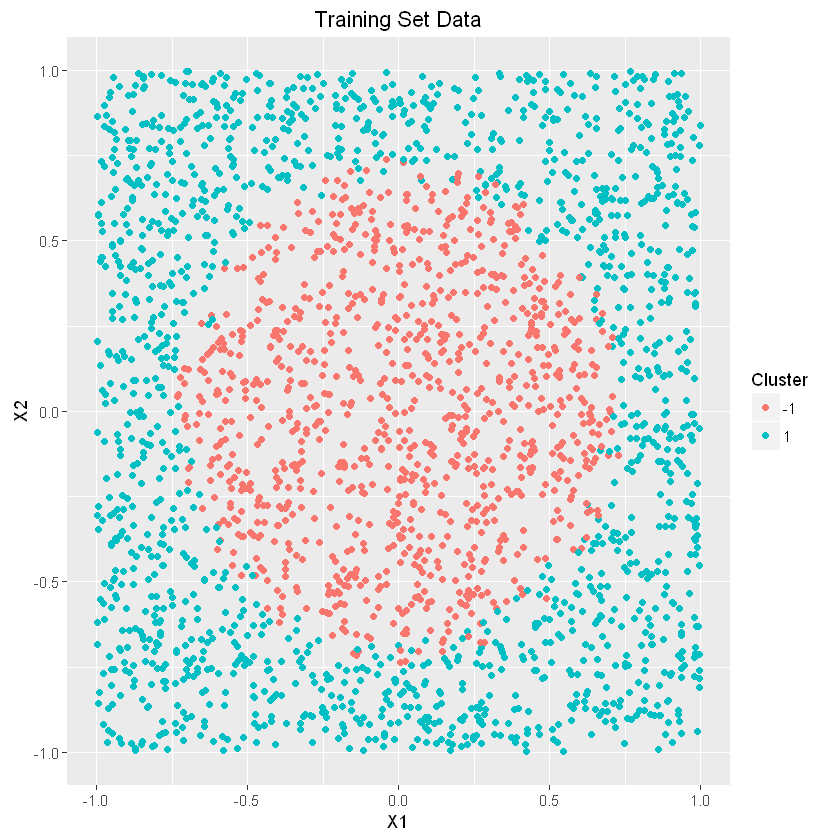

In [13]:
# Read the datasets
require(ggplot2)
set.seed(1234)          # set random seed
library(ggplot2)        # load libraries
list[X1,T1] <- read.data('./Task3B_train.csv') # read training data
T1[T1==0] <- -1         # convert 0 labels to -1 
list[X2,T2] <- read.data('./Task3B_test.csv') # read test data
T2[T2==0] <- -1         # convert 0 labels to -1 

plt_ <- as.data.frame(cbind(X1, T1));


ggplot(data = plt_, aes(x = plt_$x1, y = plt_$x2)) + geom_point(aes(colour = as.factor(plt_$T1))) + ggtitle("Training Set Data") + ylab("X2") + xlab("X1") + labs(colour = "Cluster");

### ii
Run the implementations of Perceptron given to you in Activity 3.1, calculate the test
error, and plot the test data while the points are colored with their estimated class
labels; attach the pdf to your report.

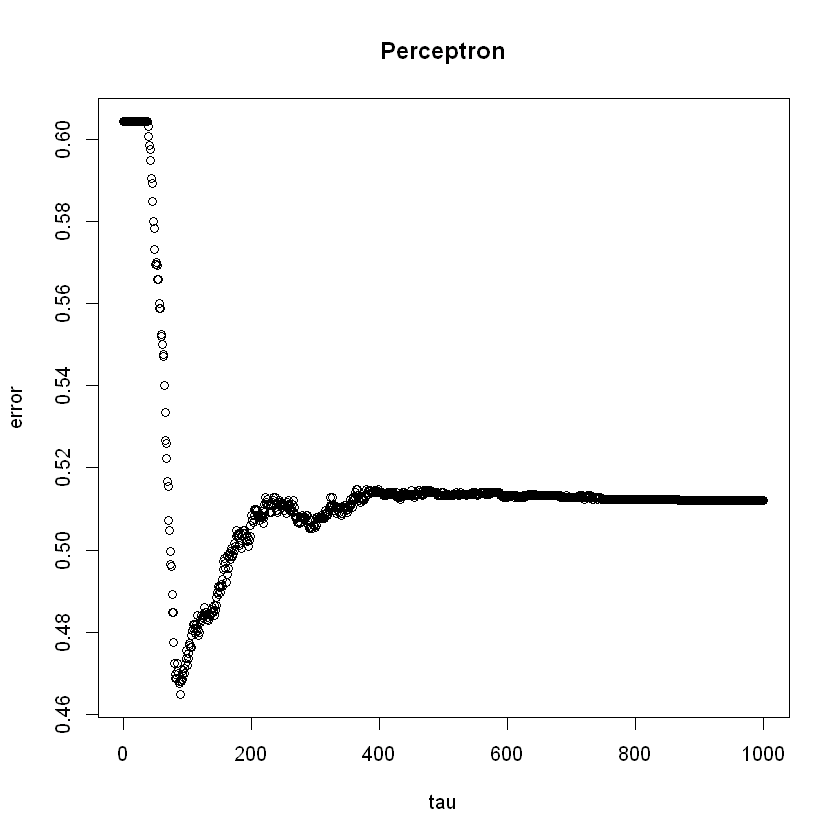

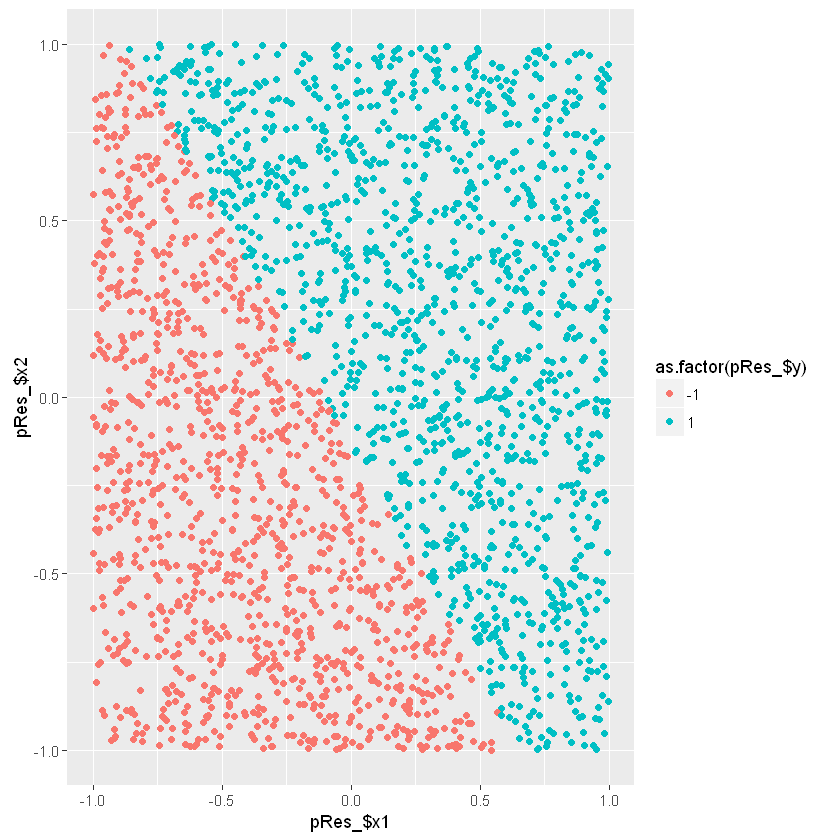

In [14]:
# build perceptron
W <- perceptron.build(X1, T1, tau.max = 1000, plotting = TRUE)

# calculate error
perceptronError_ <- error.rate(perceptron.predict(as.matrix(cbind(1, X2)), W), T2);

# predict and print
pRes_ <- perceptron.predict(as.matrix(cbind(1, X2)), W)
pRes_ <- cbind(X2, pRes_);
colnames(pRes_) <- c("x1", "x2", "y");
ggplot(data = pRes_, aes(x = pRes_$x1, y = pRes_$x2)) + geom_point(aes(colour = as.factor(pRes_$y)))

### iii
Run the 3-layer Neural Network given to you in Activity 5.1 with different values of K (i.e, number of units in the hidden layer) and record testing error for each of them; plot the error vs K and attach it to your report. Based on this plot, find the best K and the corresponding model, then plot the test data while the points are colored with their estimated class labels using the best model that you have selected; attach the plot to your report.

[1] "Completed :  2"


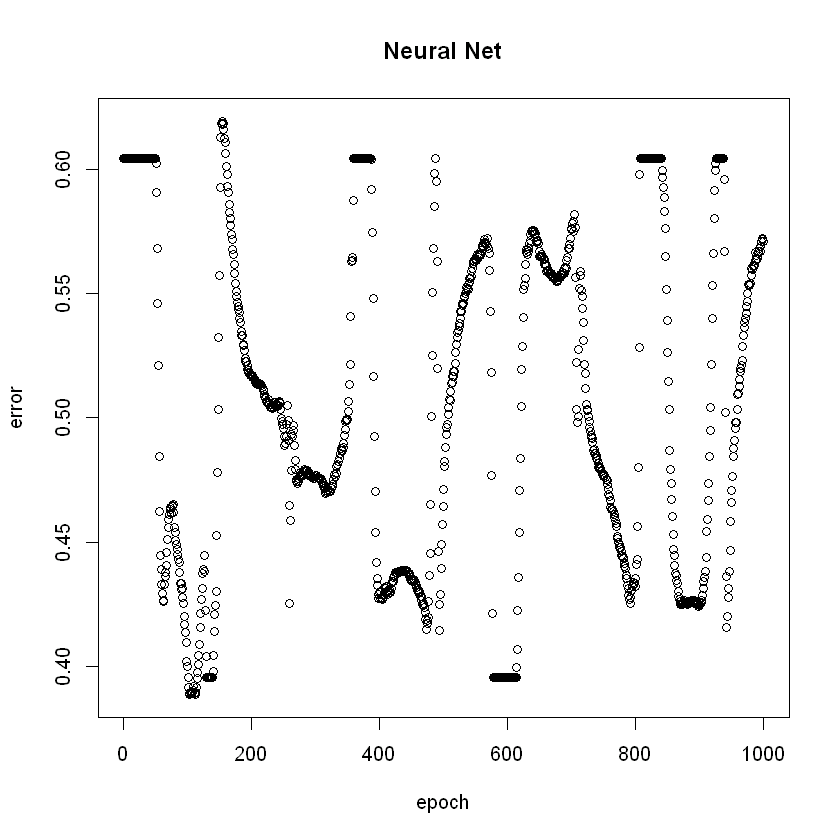

[1] "Completed :  4"


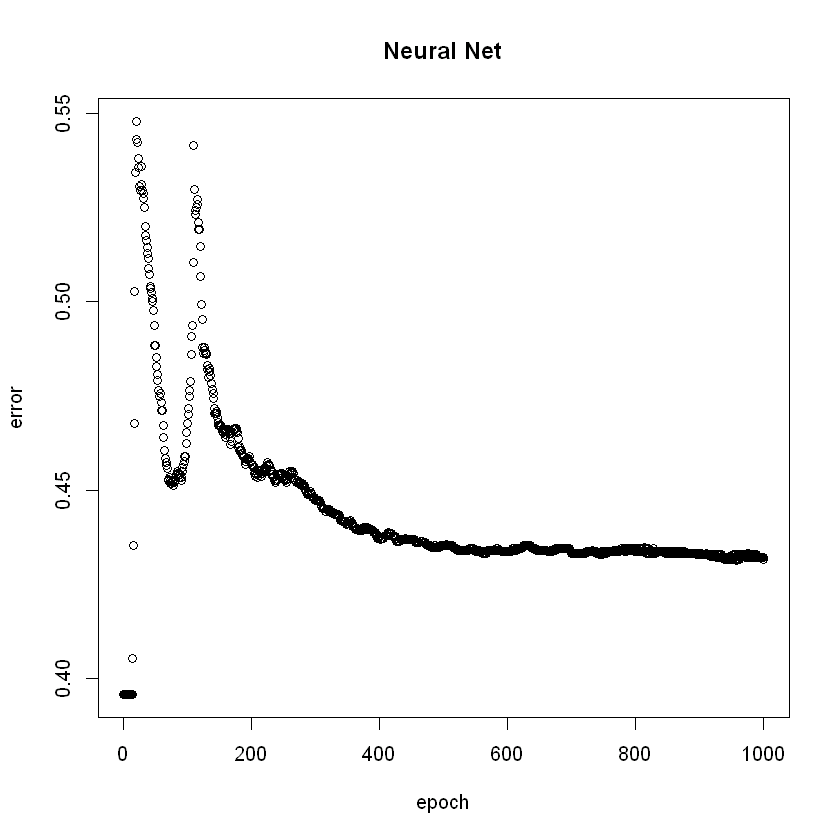

[1] "Completed :  6"


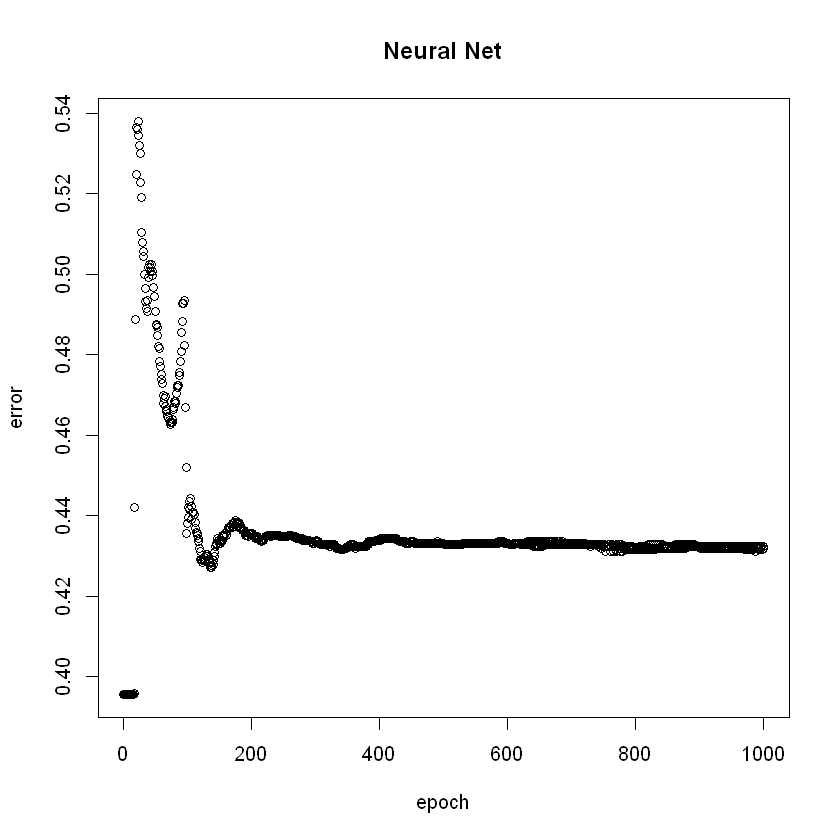

[1] "Completed :  8"


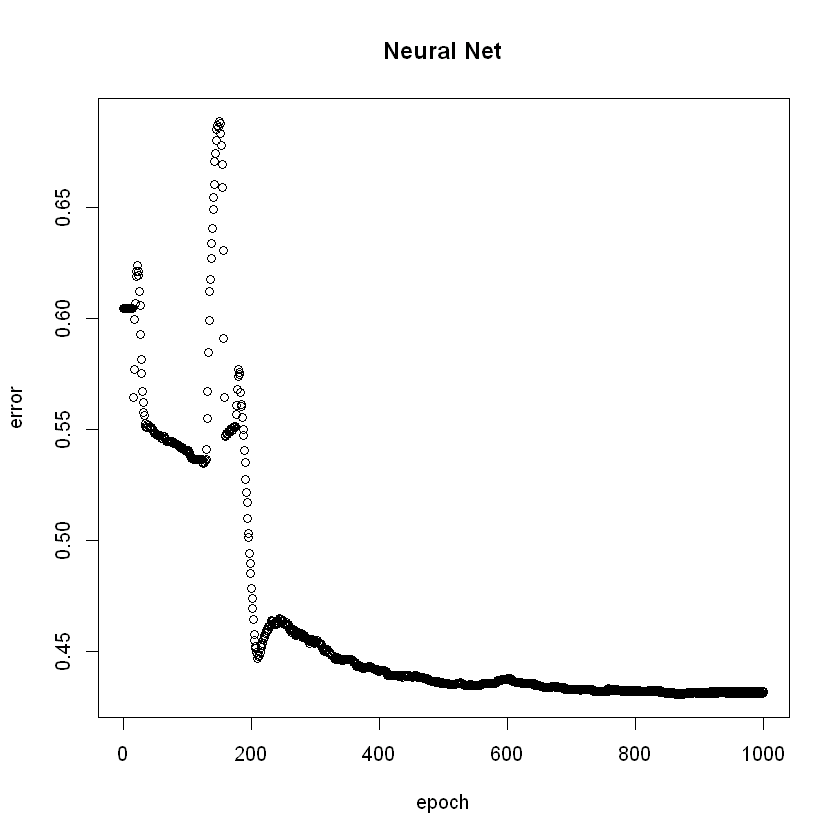

[1] "Completed :  10"


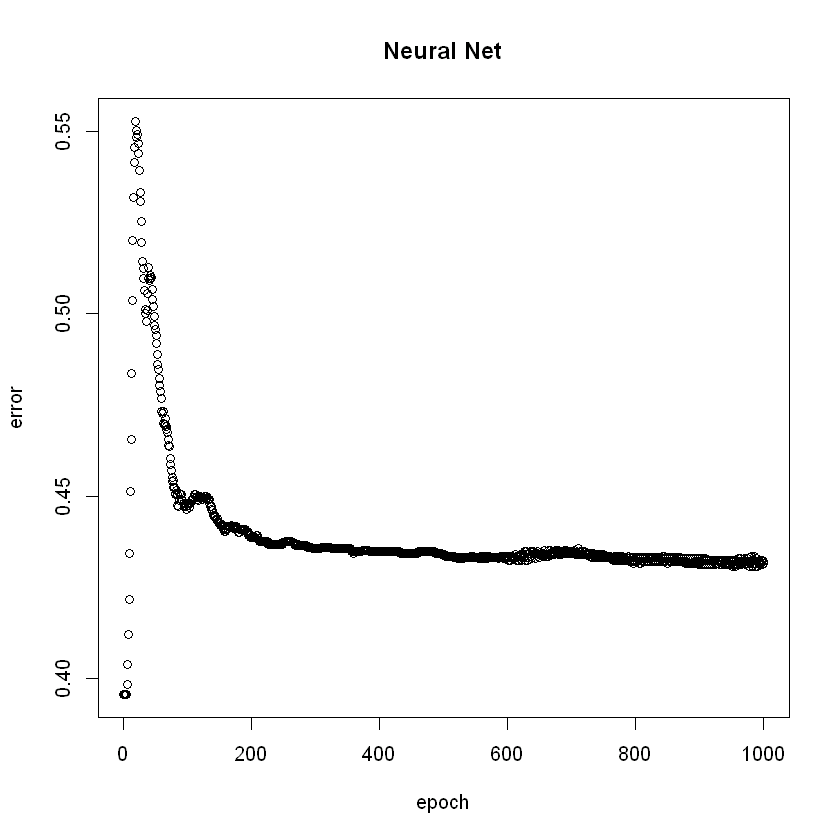

[1] "Completed :  12"


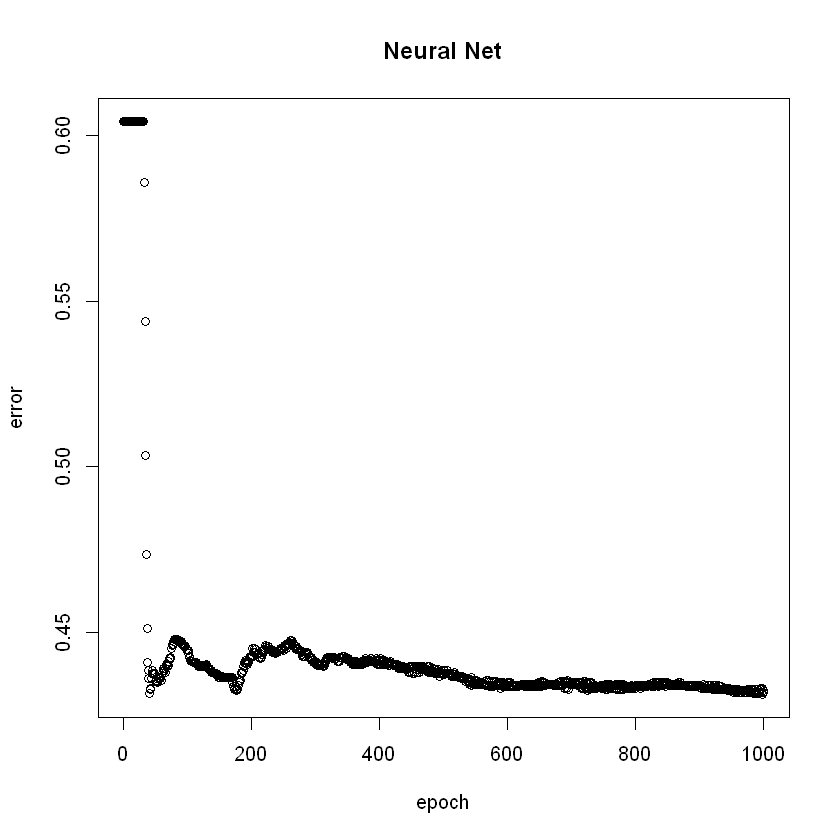

[1] "Completed :  14"


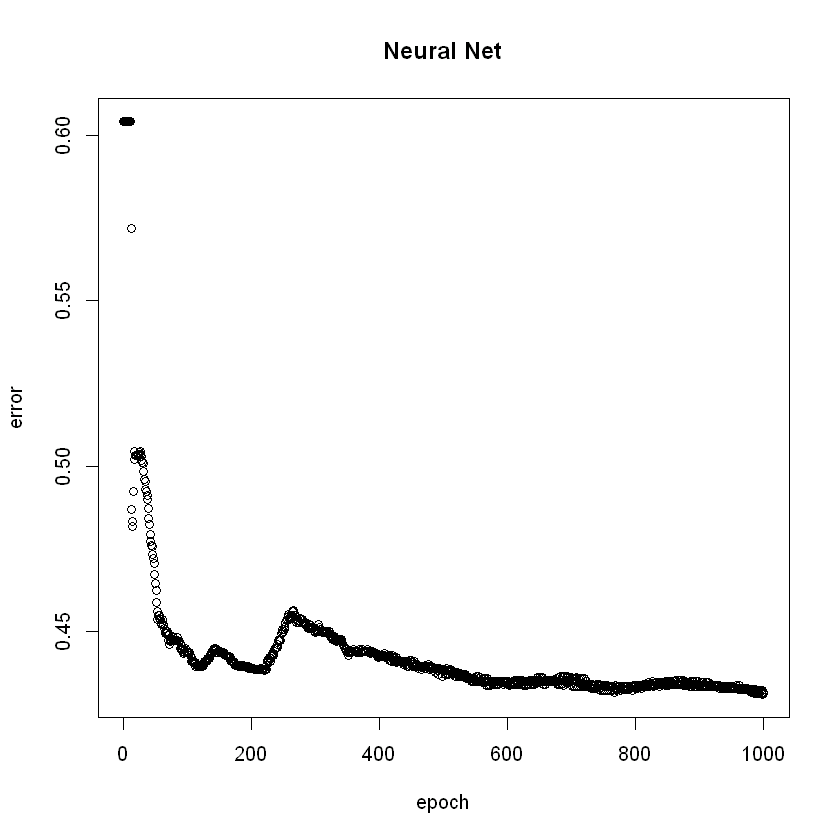

[1] "Completed :  16"


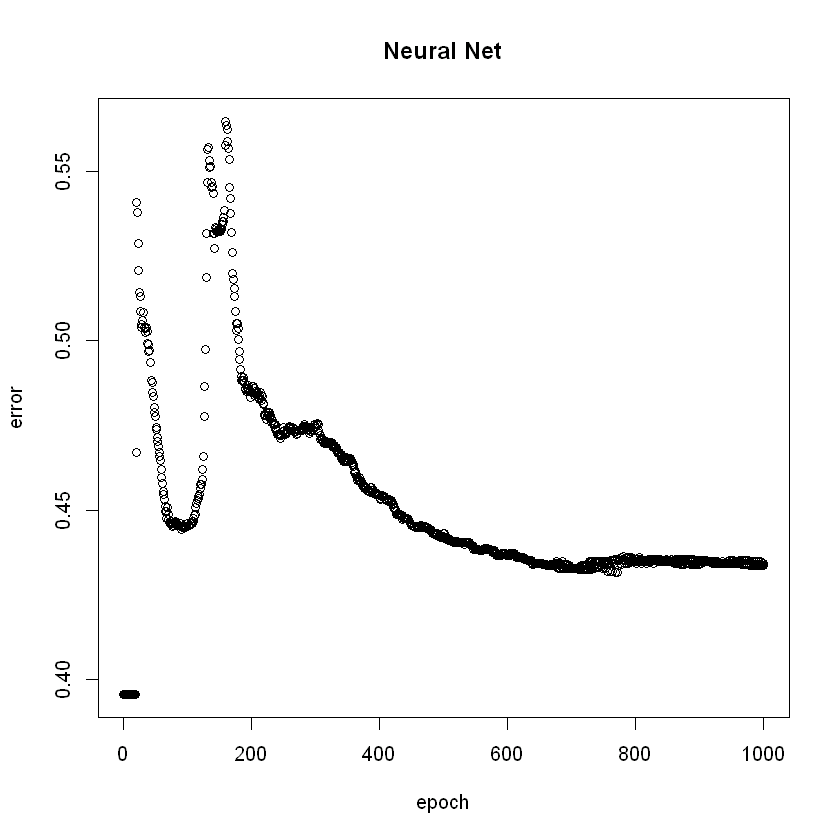

[1] "Completed :  18"


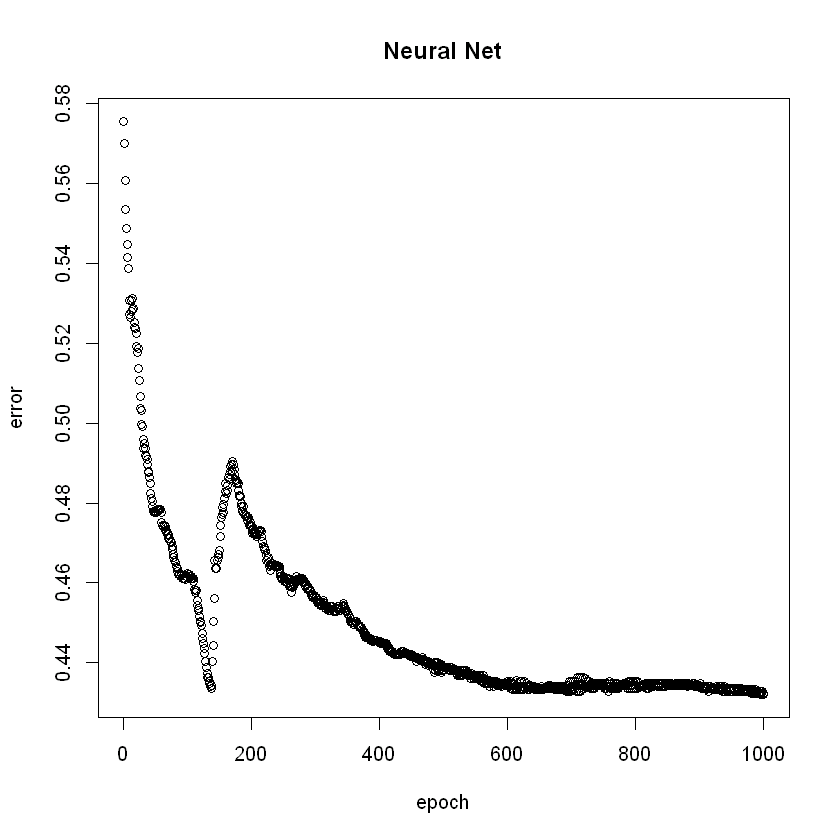

[1] "Completed :  20"


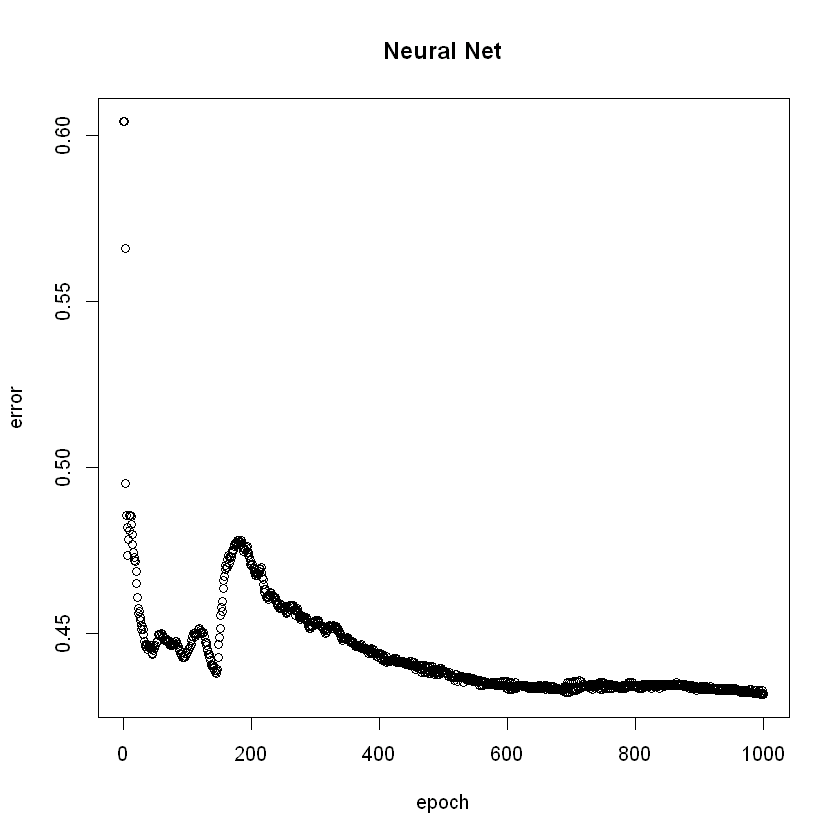

[1] "Completed :  22"


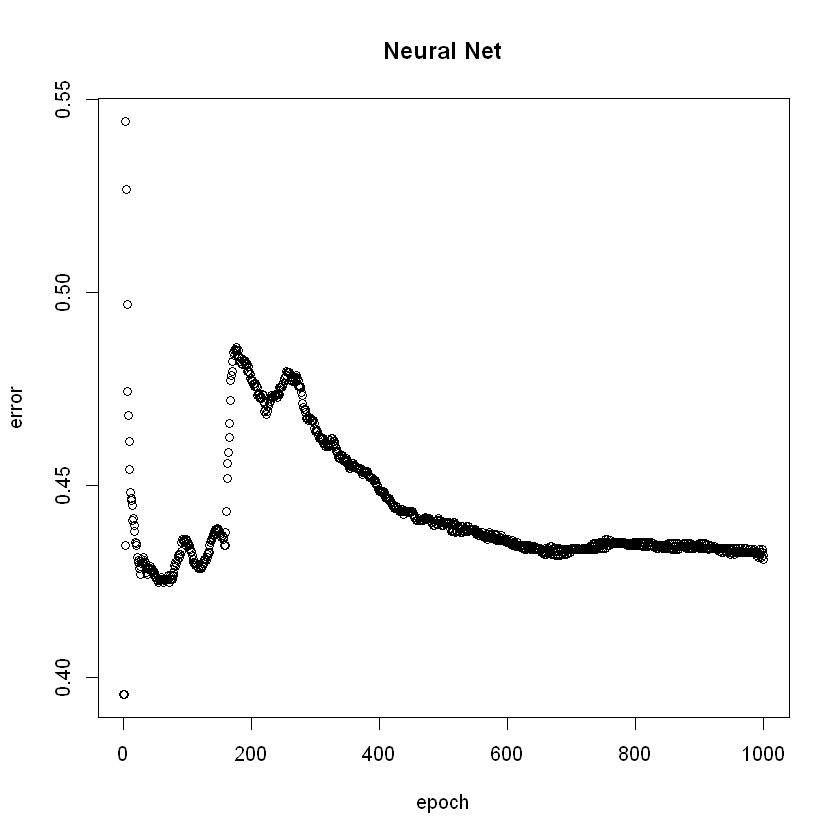

[1] "Completed :  24"


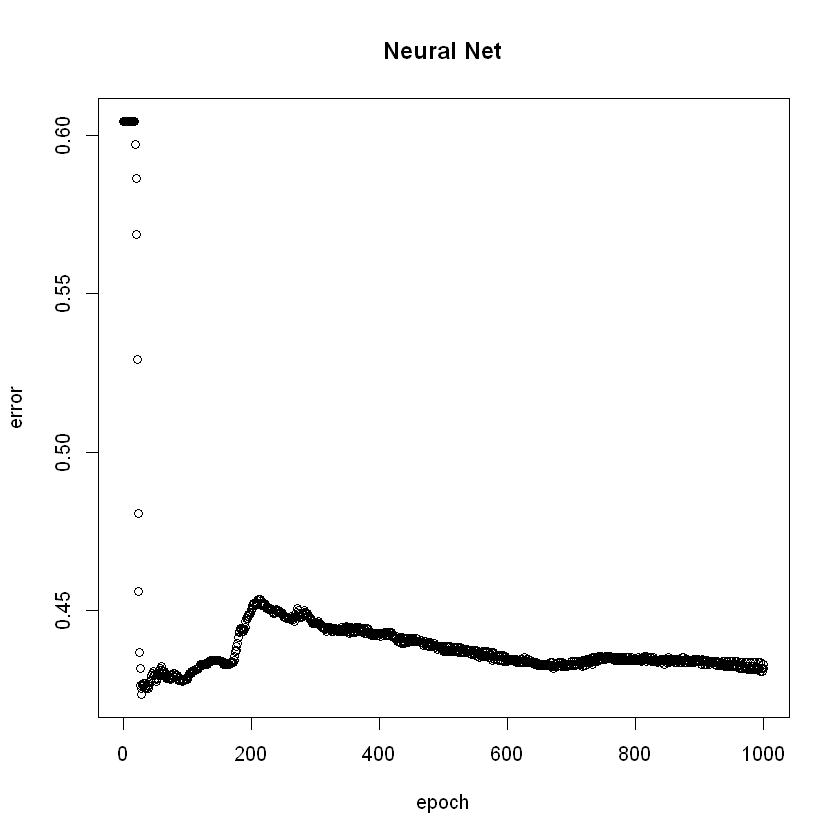

[1] "Completed :  26"


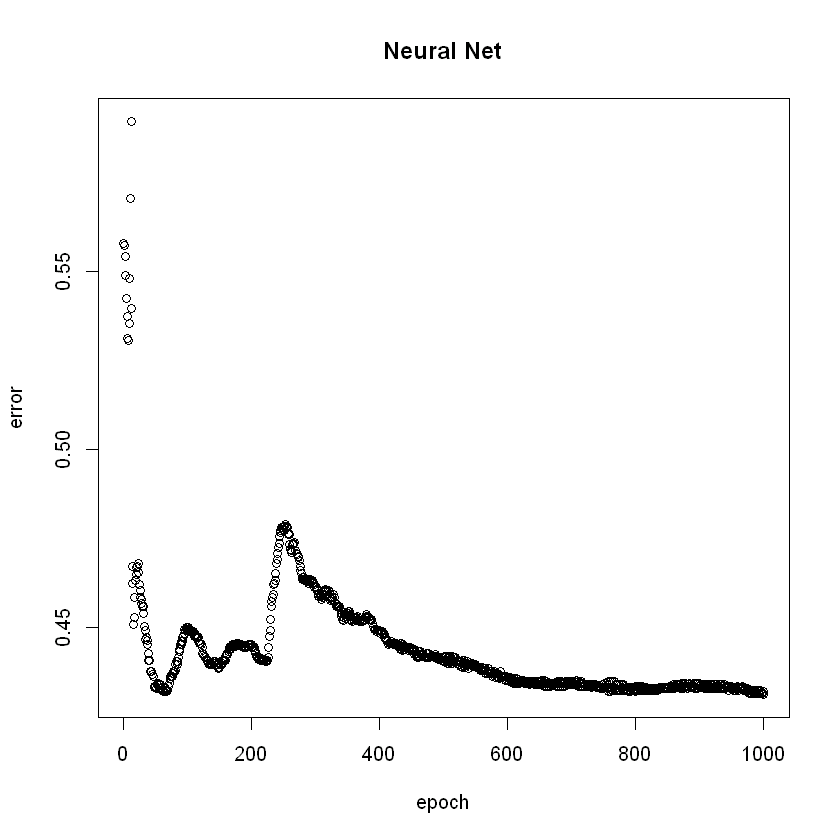

[1] "Completed :  28"


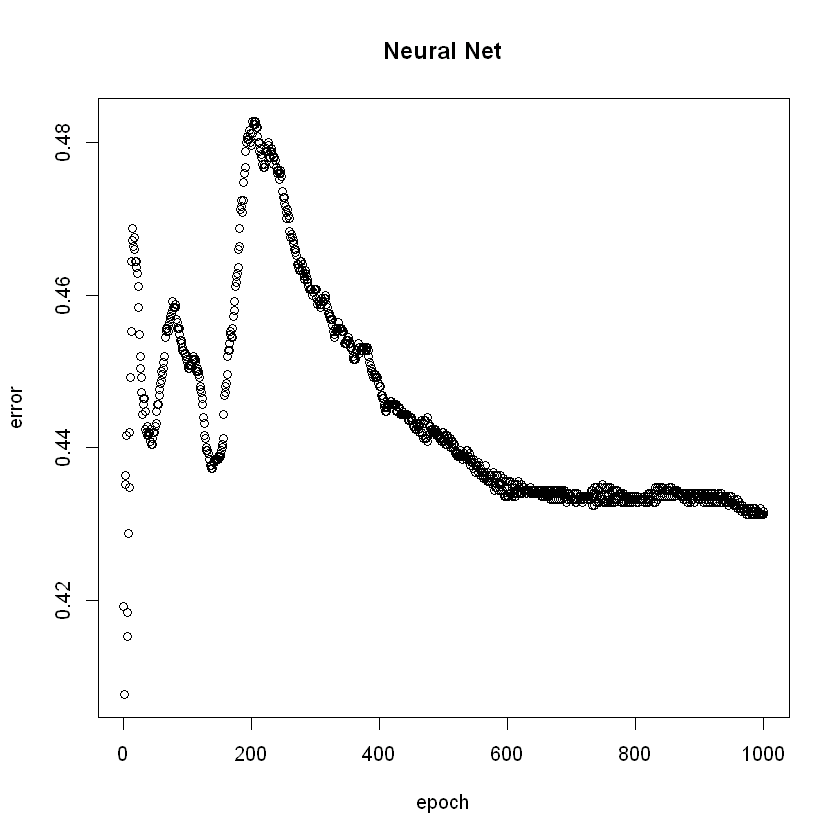

[1] "Completed :  30"


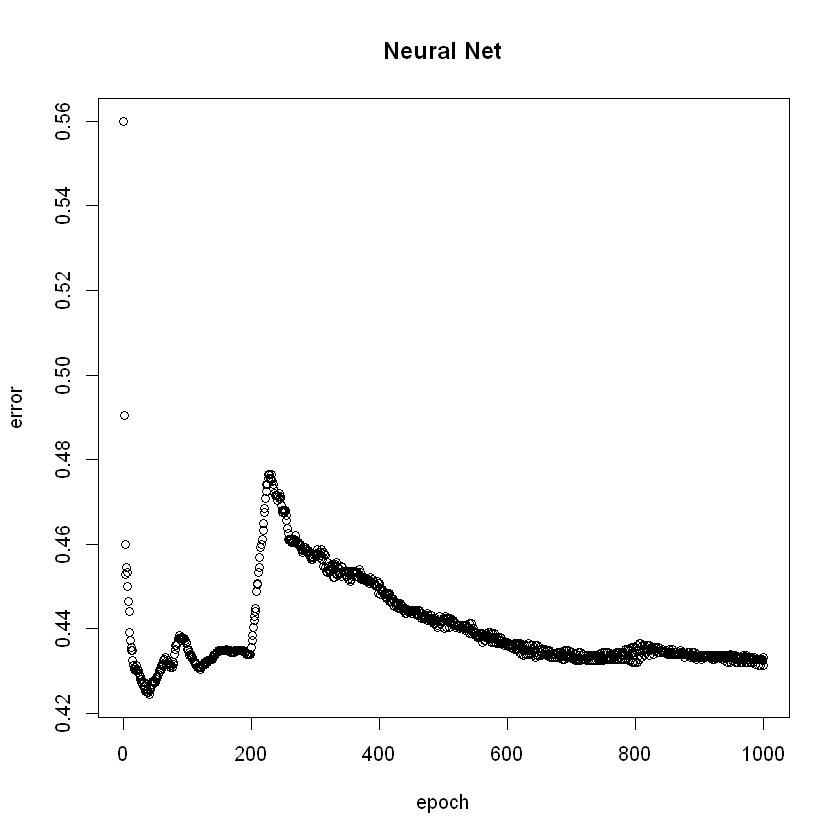

[1] "Completed :  32"


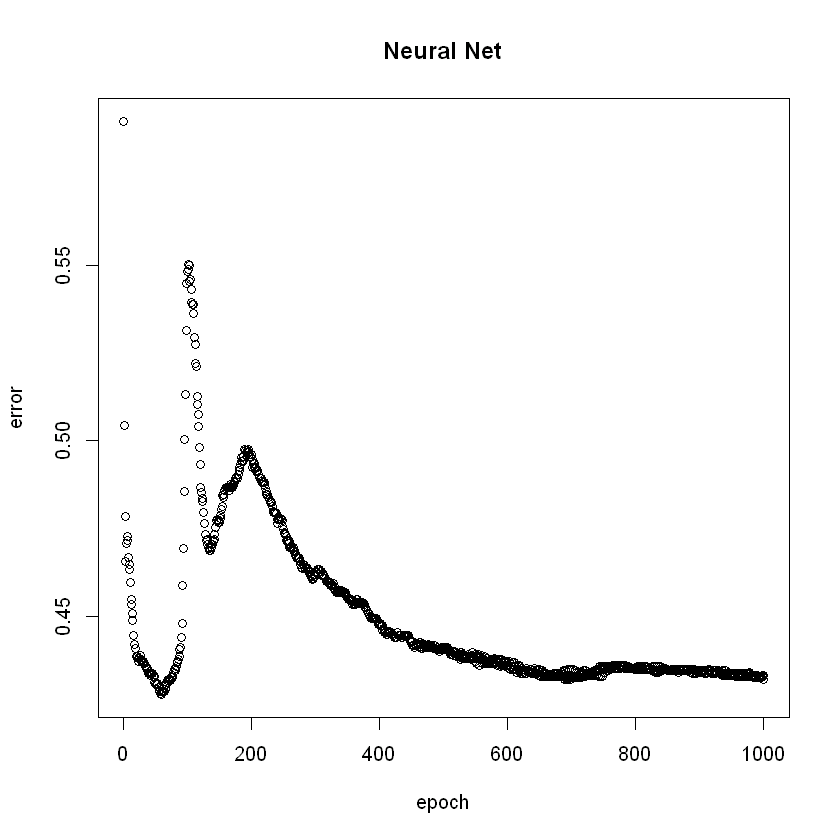

[1] "Completed :  34"


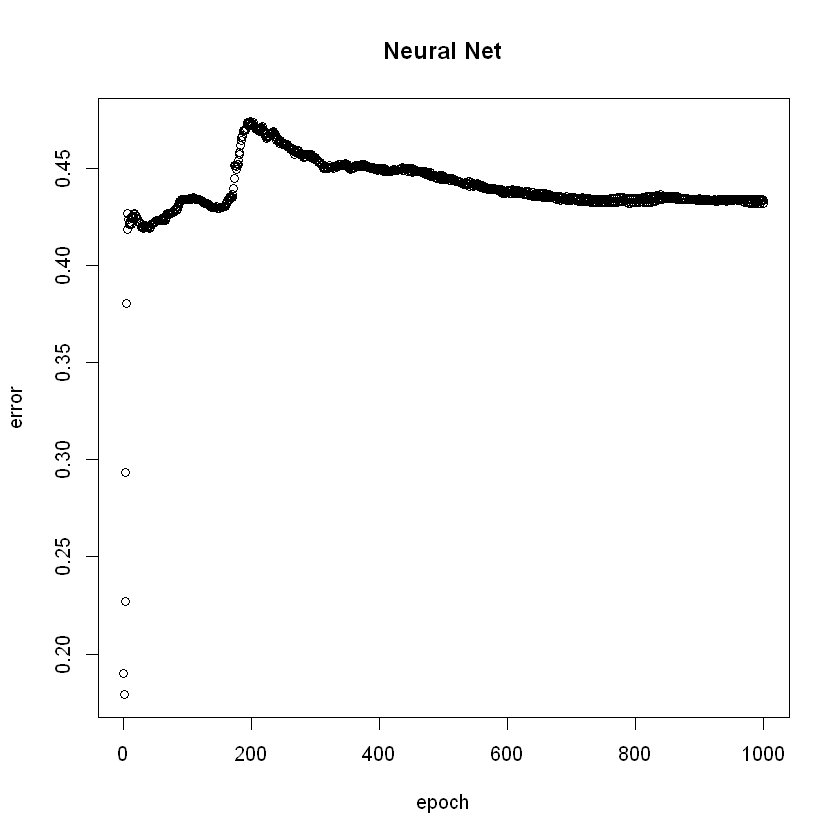

[1] "Completed :  36"


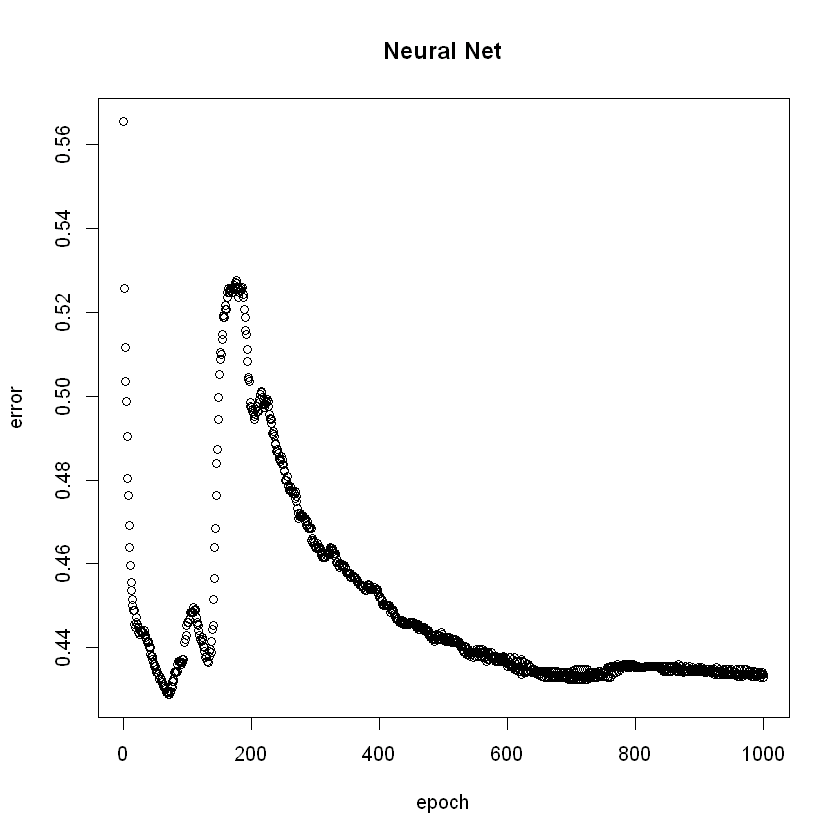

[1] "Completed :  38"


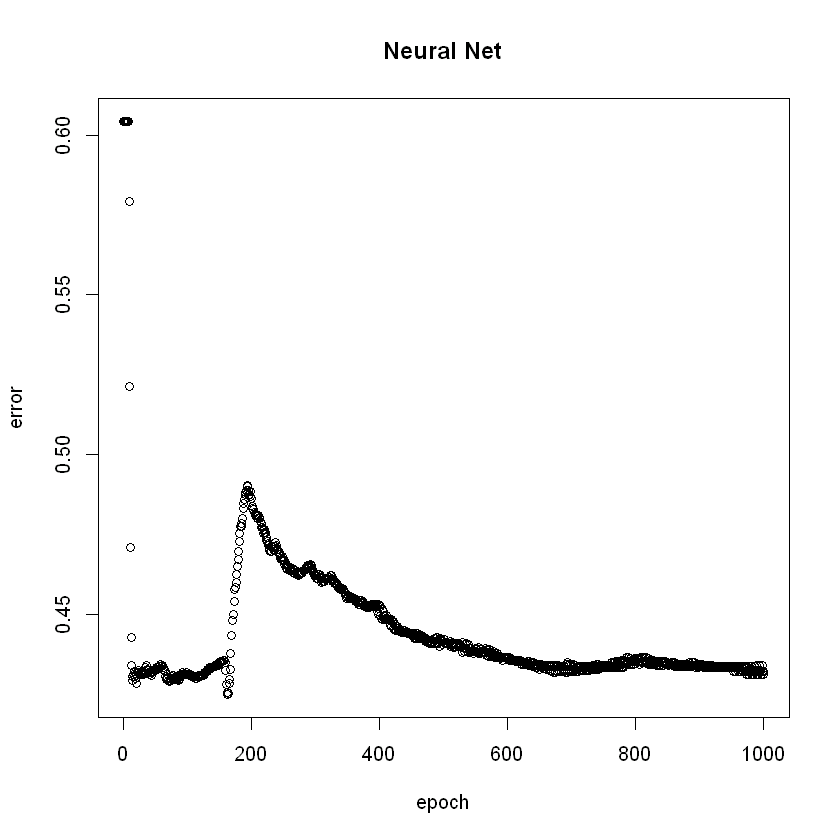

[1] "Completed :  40"


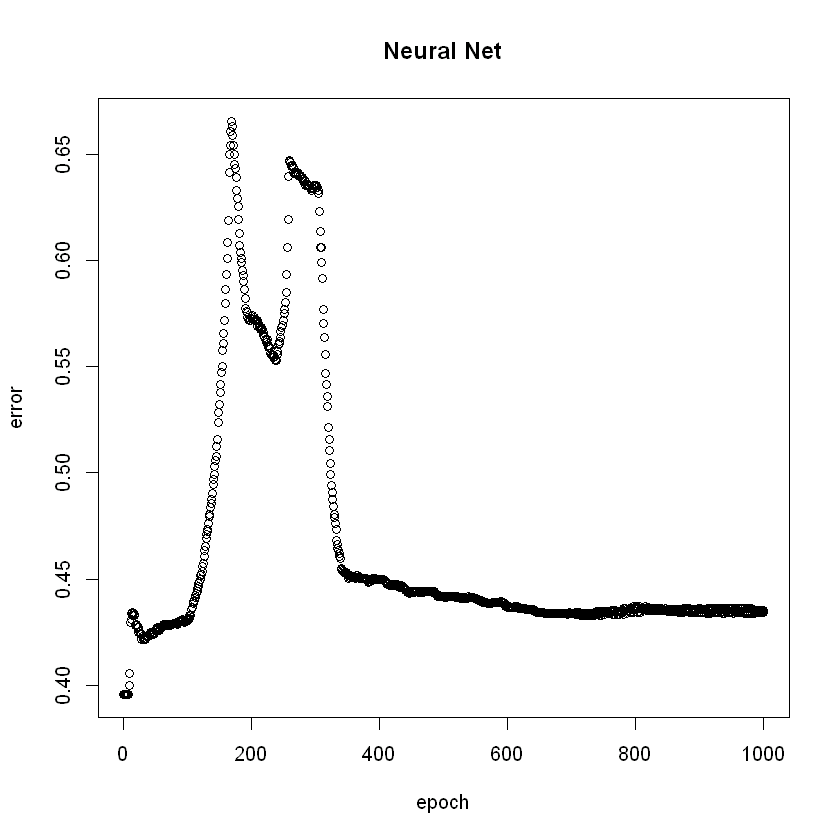

[1] "Completed :  42"


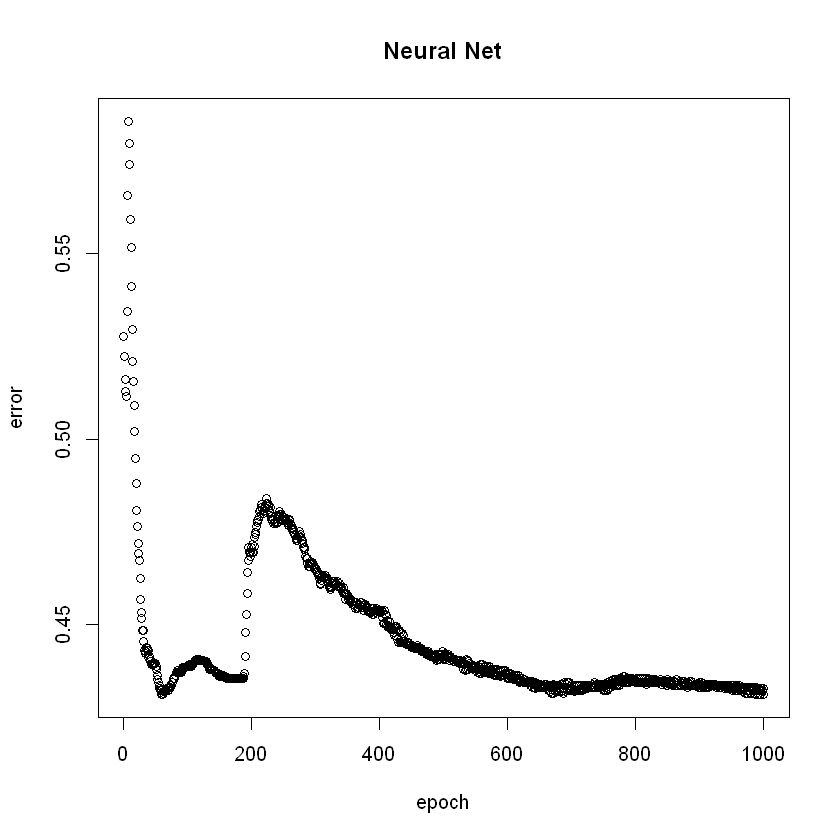

[1] "Completed :  44"


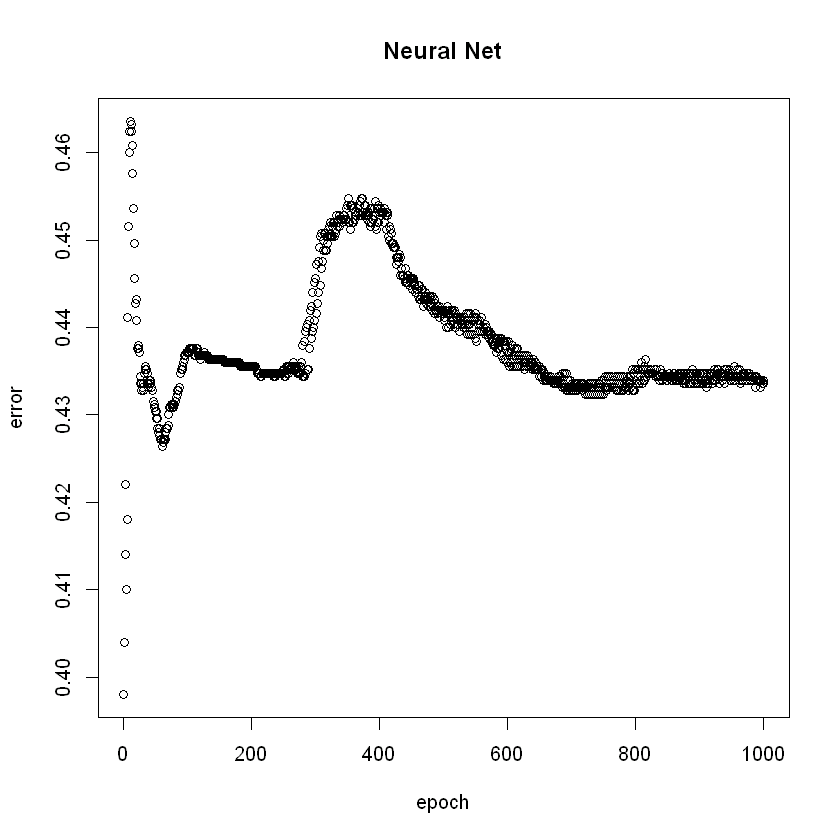

[1] "Completed :  46"


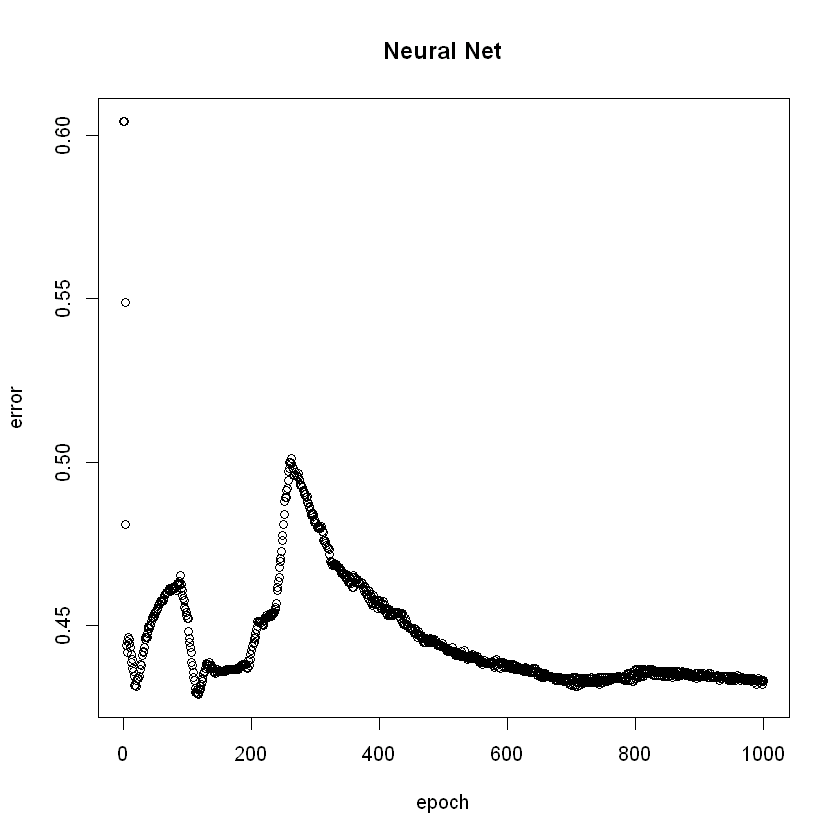

[1] "Completed :  48"


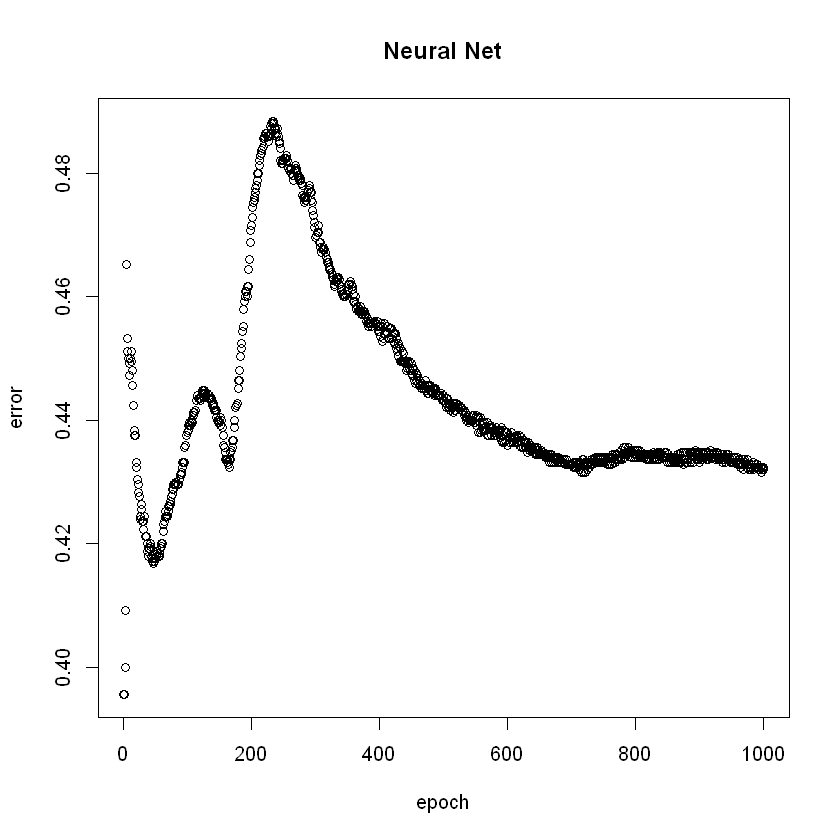

[1] "Completed :  50"


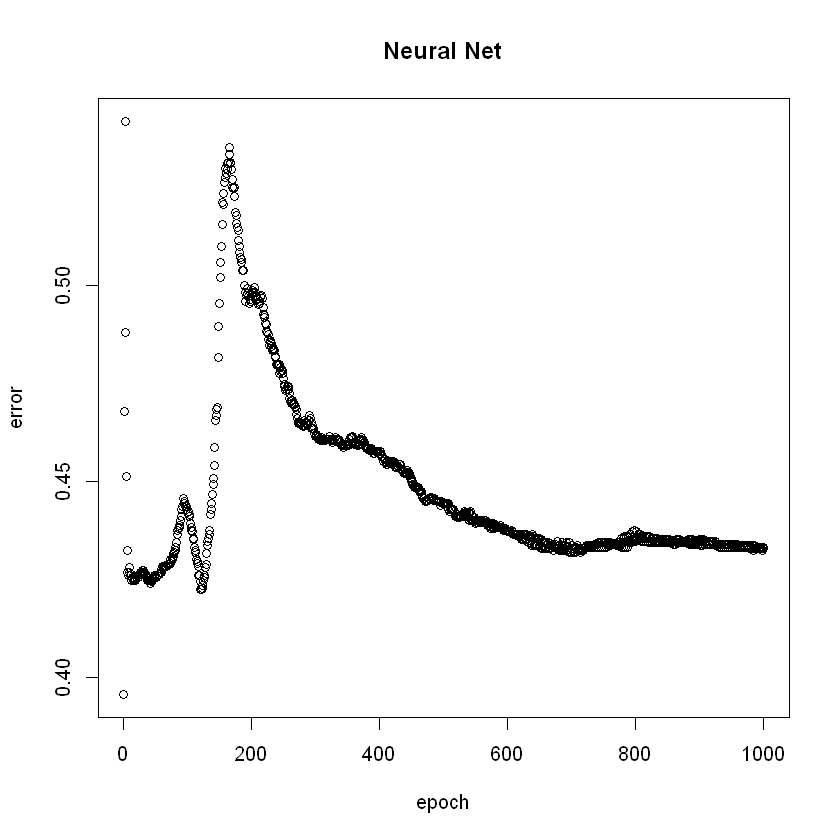

[1] "Completed :  52"


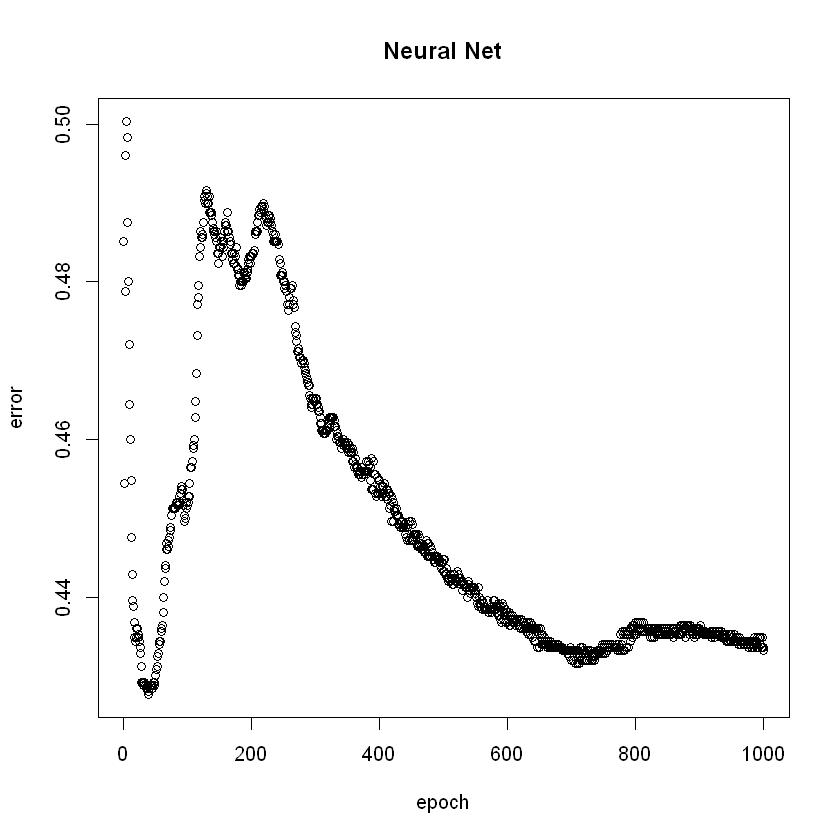

[1] "Completed :  54"


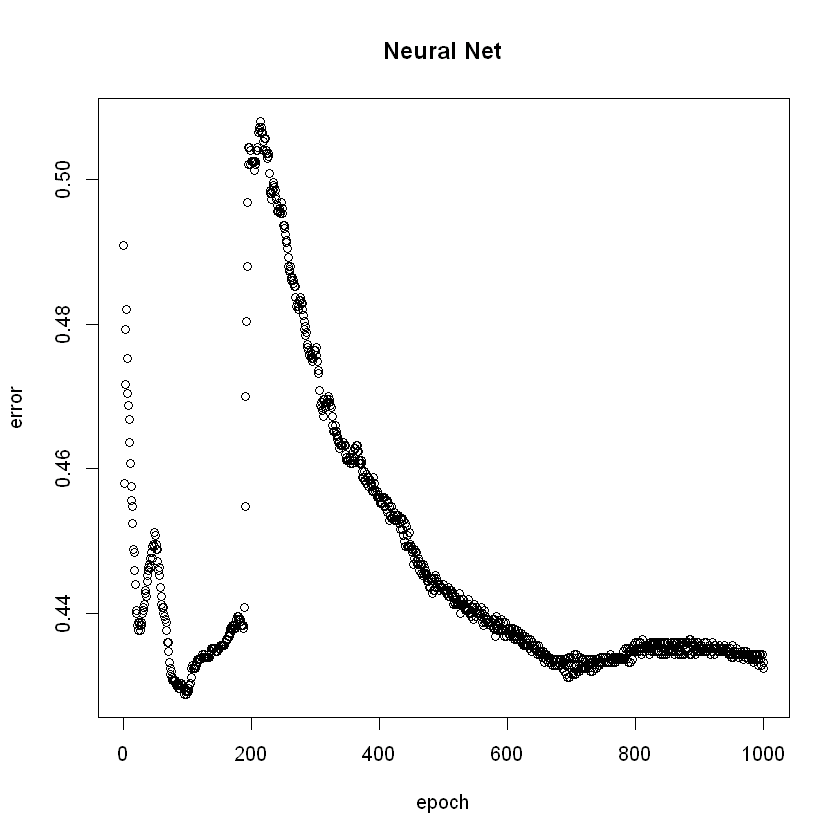

[1] "Completed :  56"


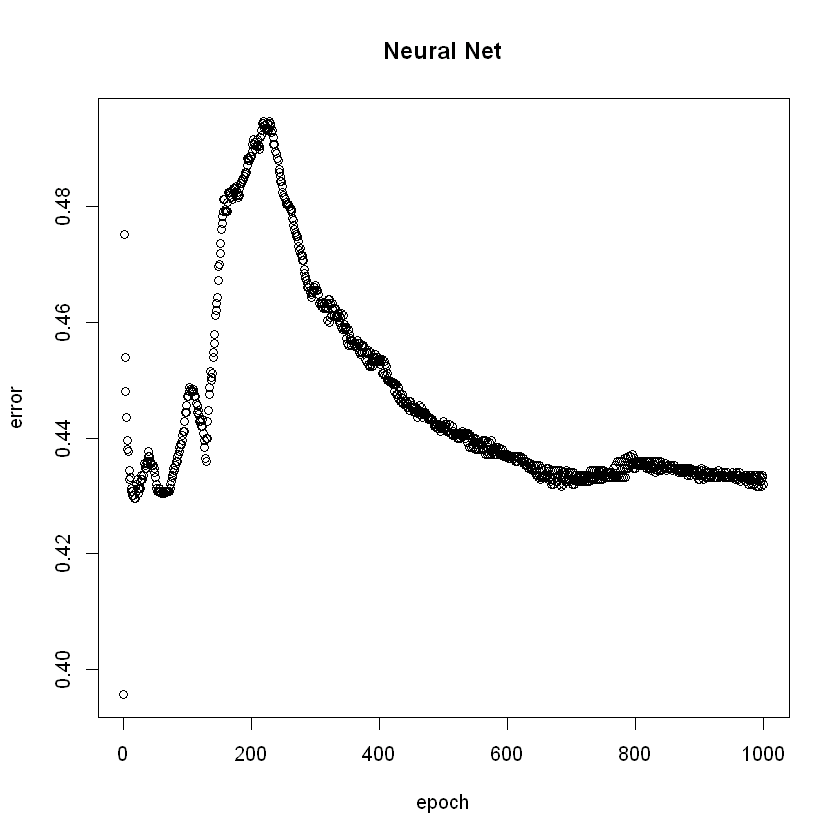

[1] "Completed :  58"


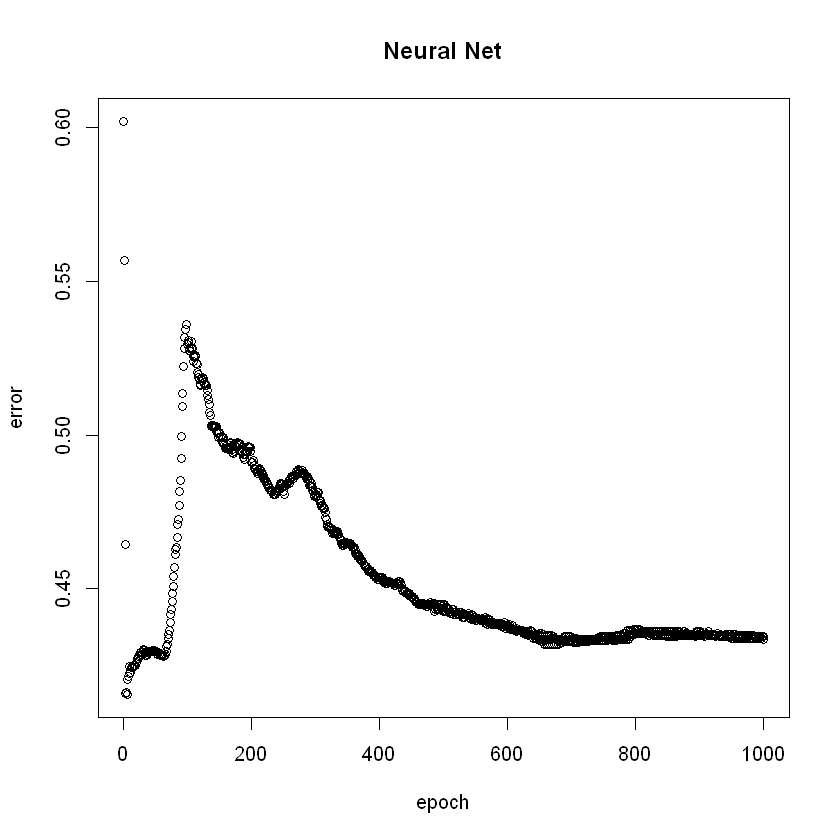

[1] "Completed :  60"


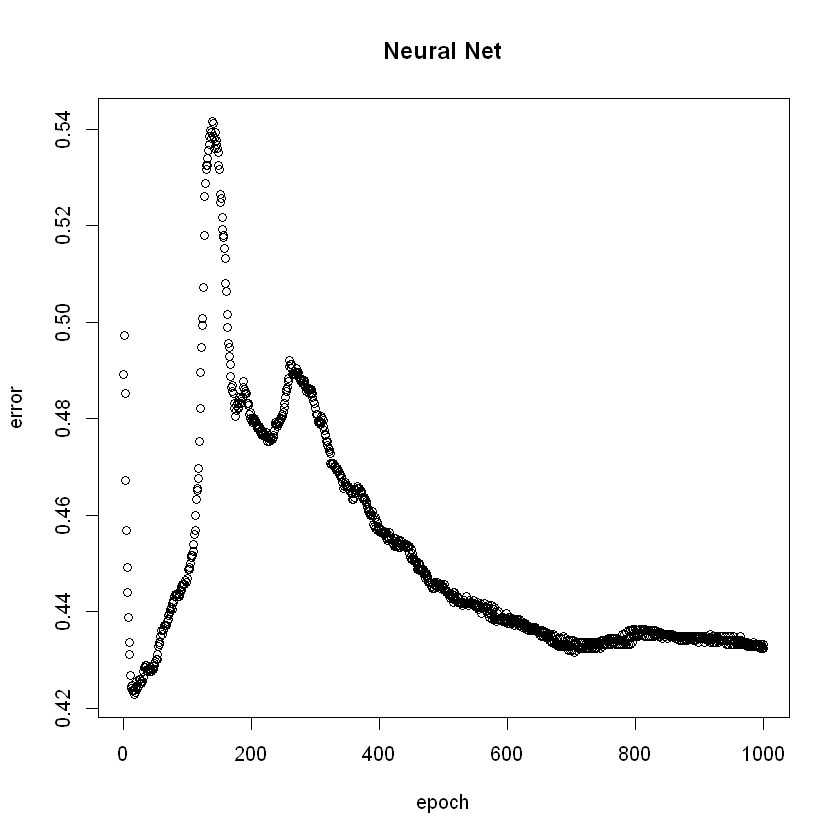

[1] "Completed :  62"


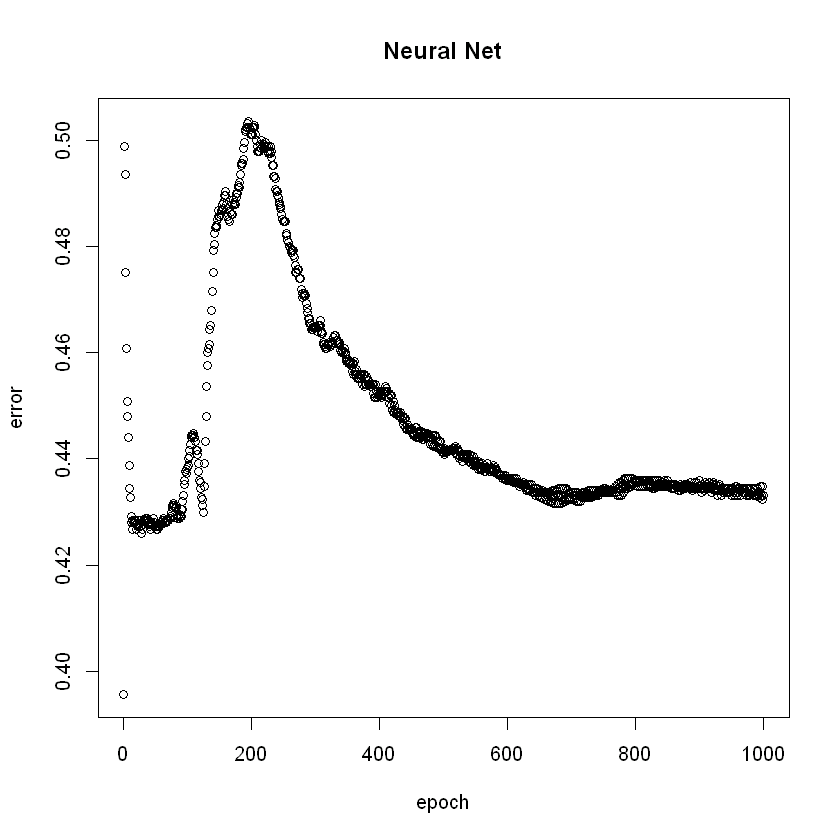

[1] "Completed :  64"


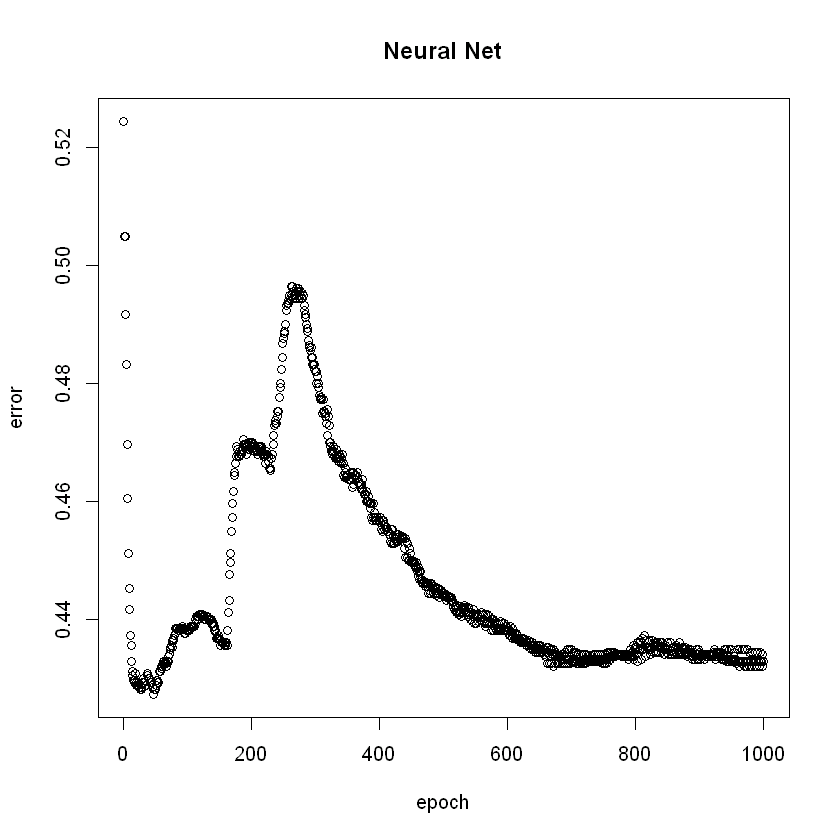

[1] "Completed :  66"


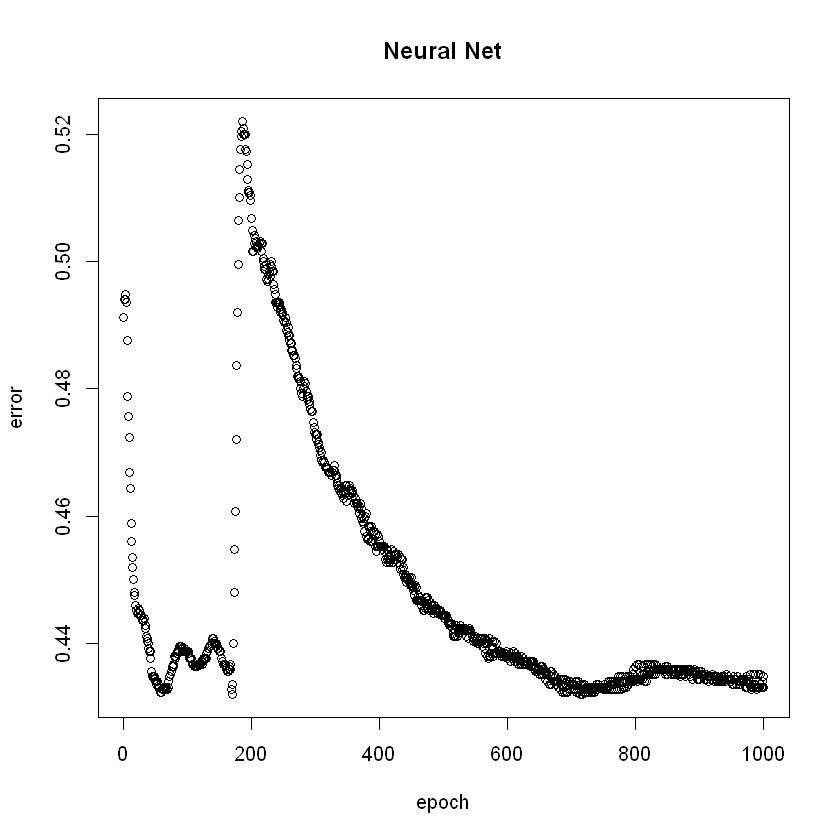

[1] "Completed :  68"


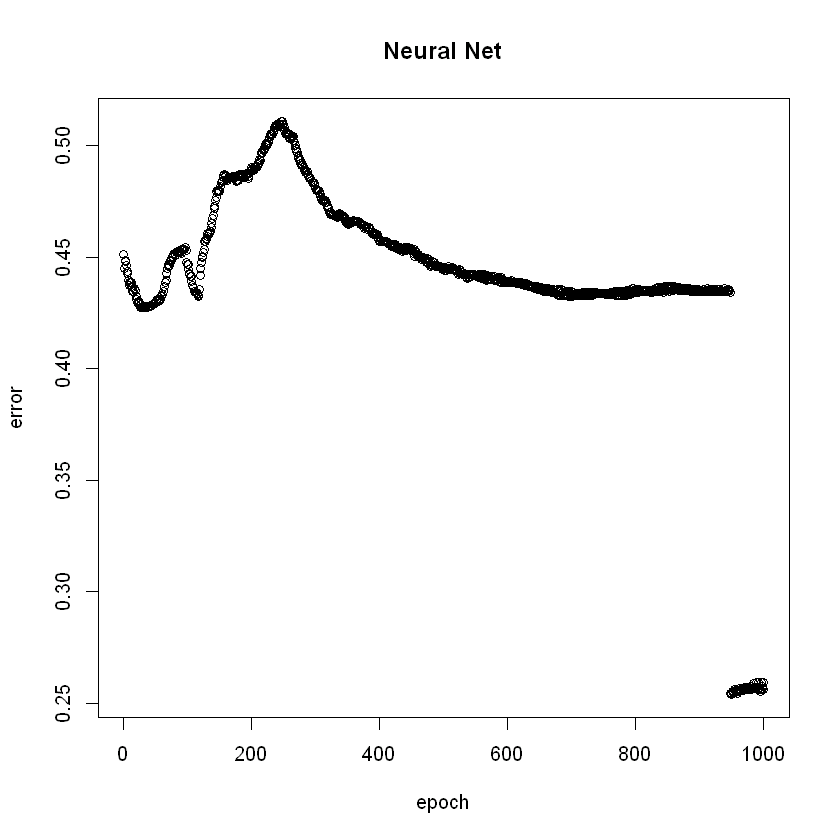

[1] "Completed :  70"


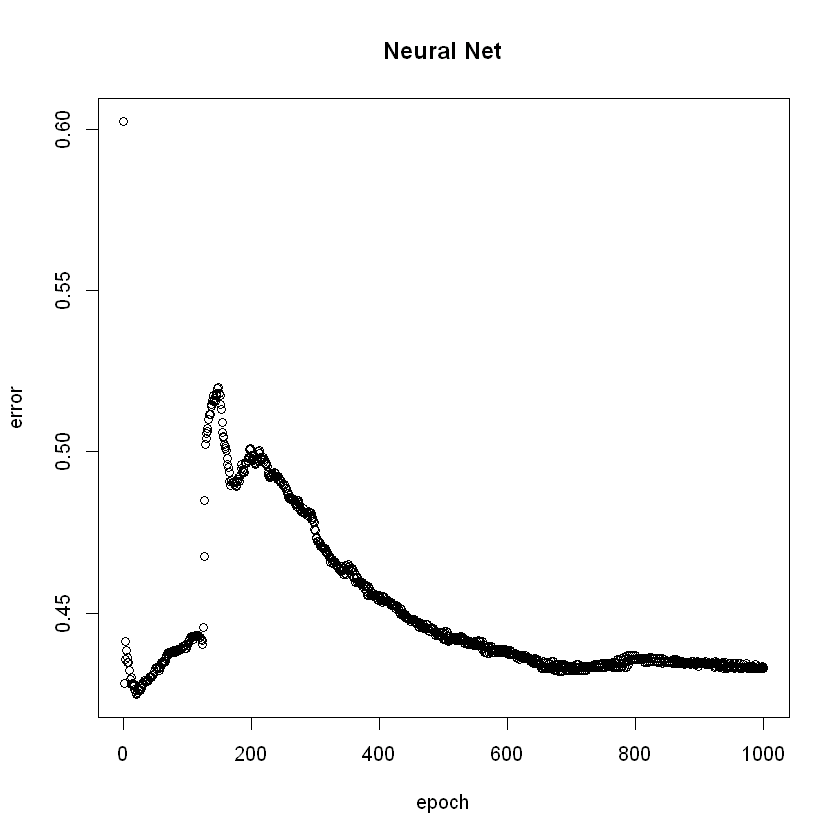

[1] "Completed :  72"


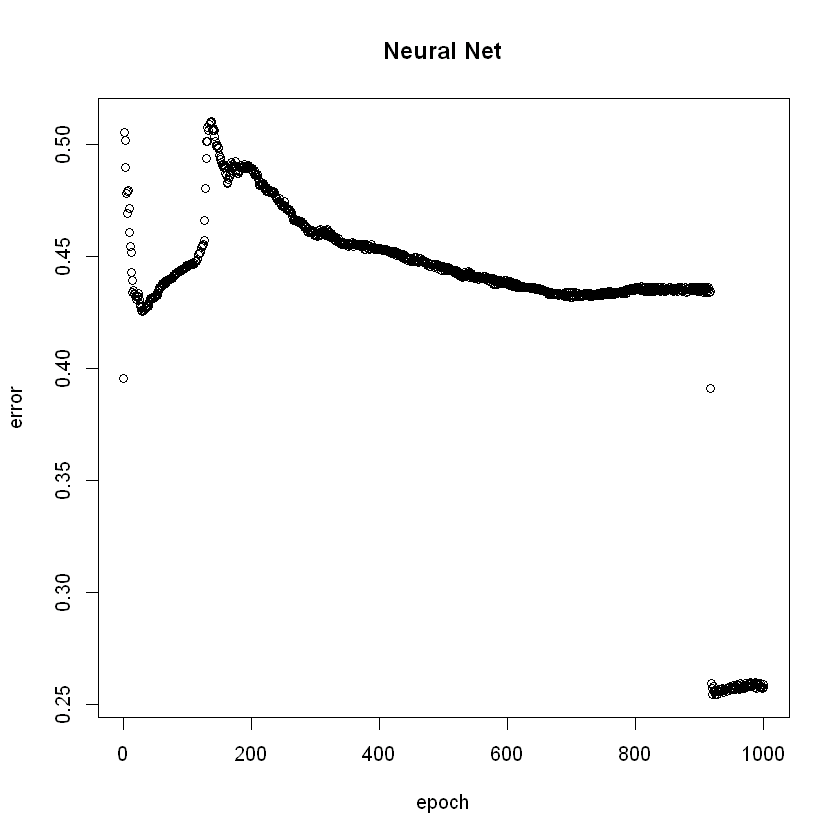

[1] "Completed :  74"


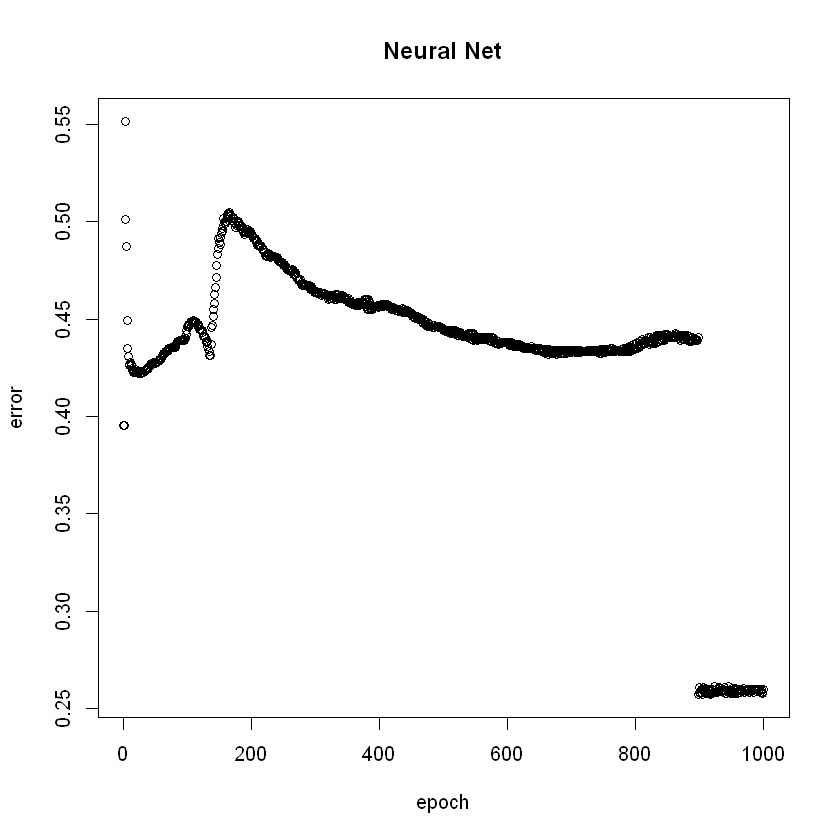

[1] "Completed :  76"


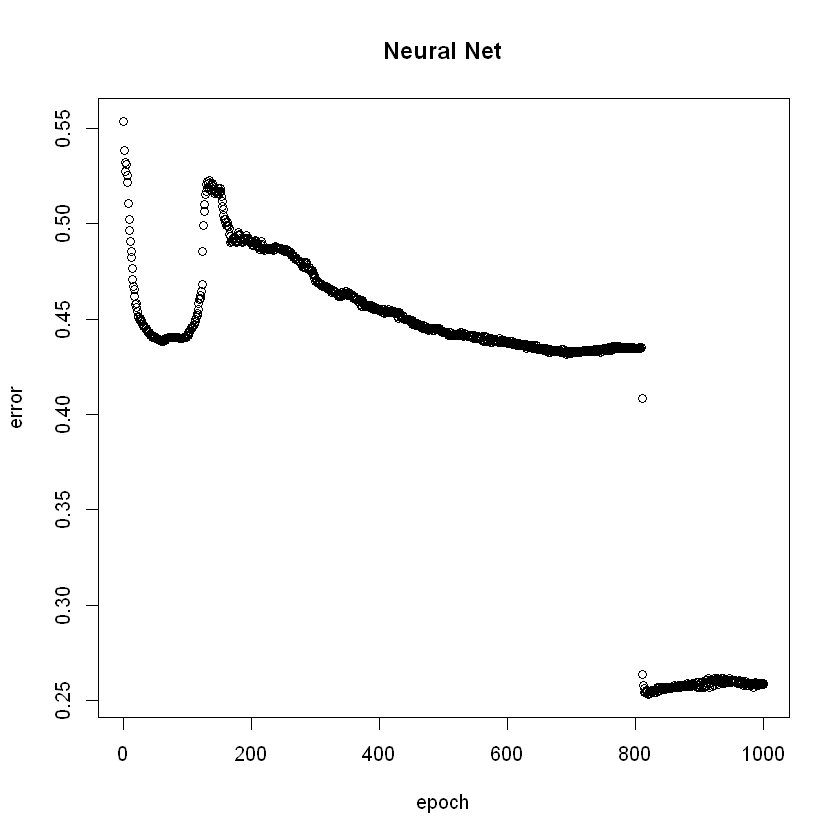

[1] "Completed :  78"


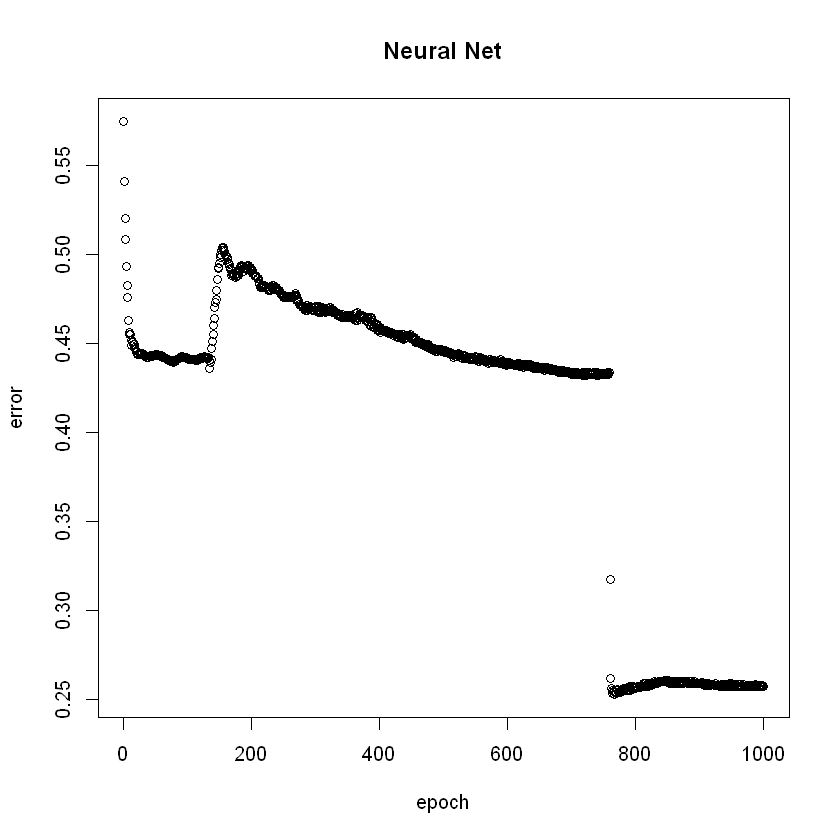

[1] "Completed :  80"


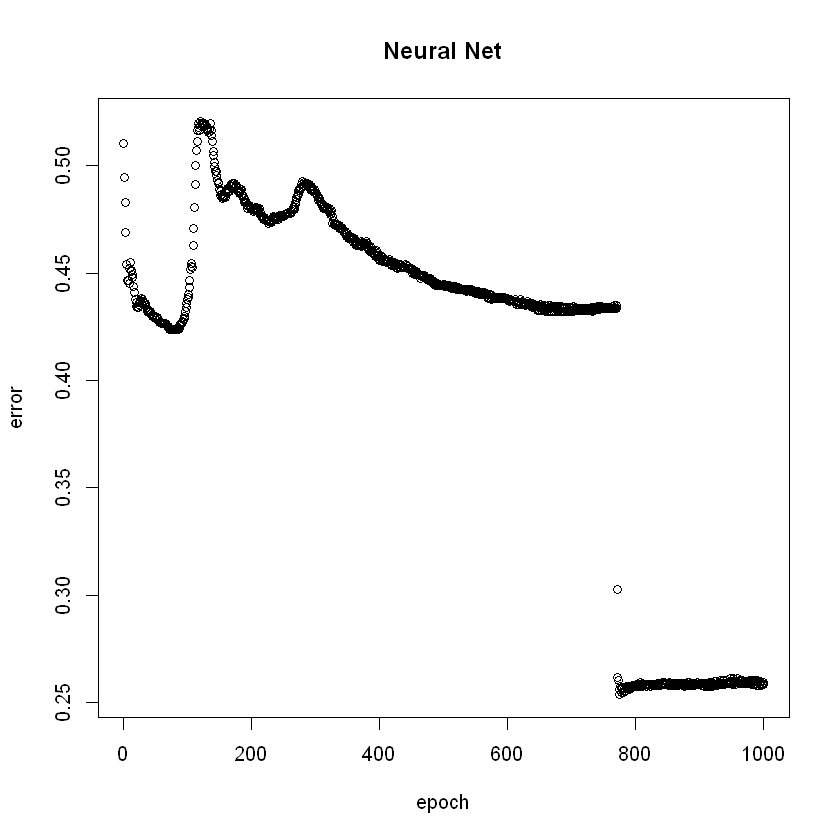

[1] "Completed :  82"


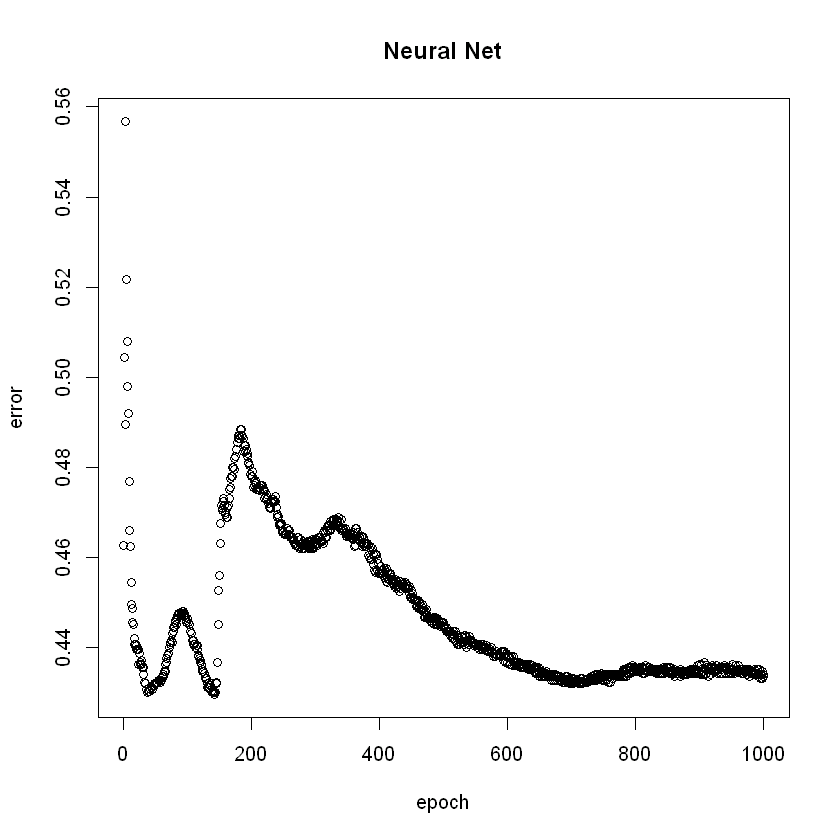

[1] "Completed :  84"


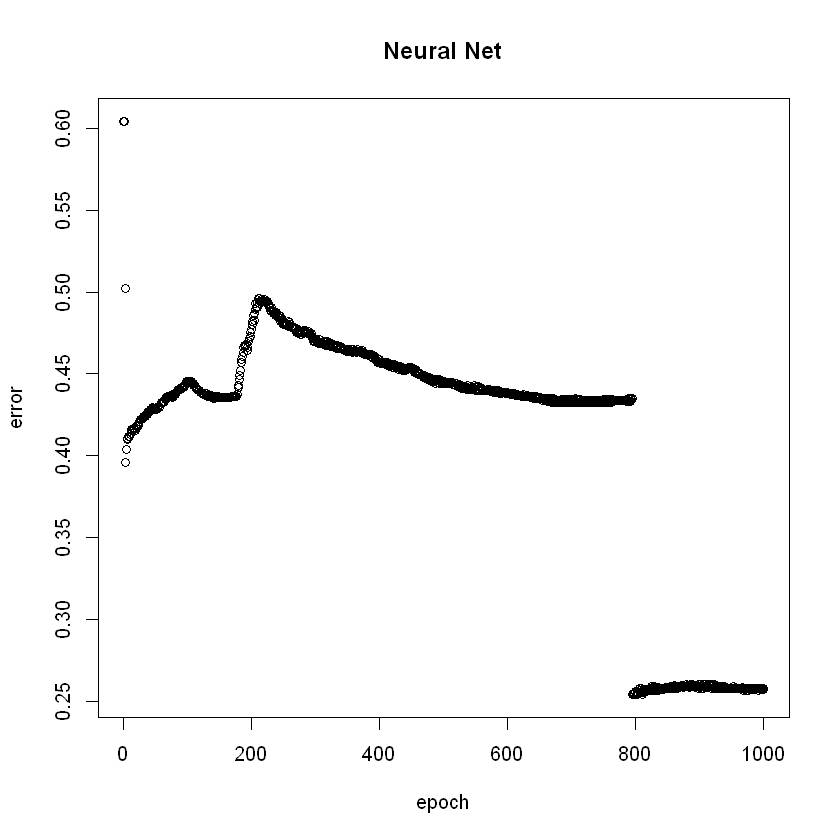

[1] "Completed :  86"


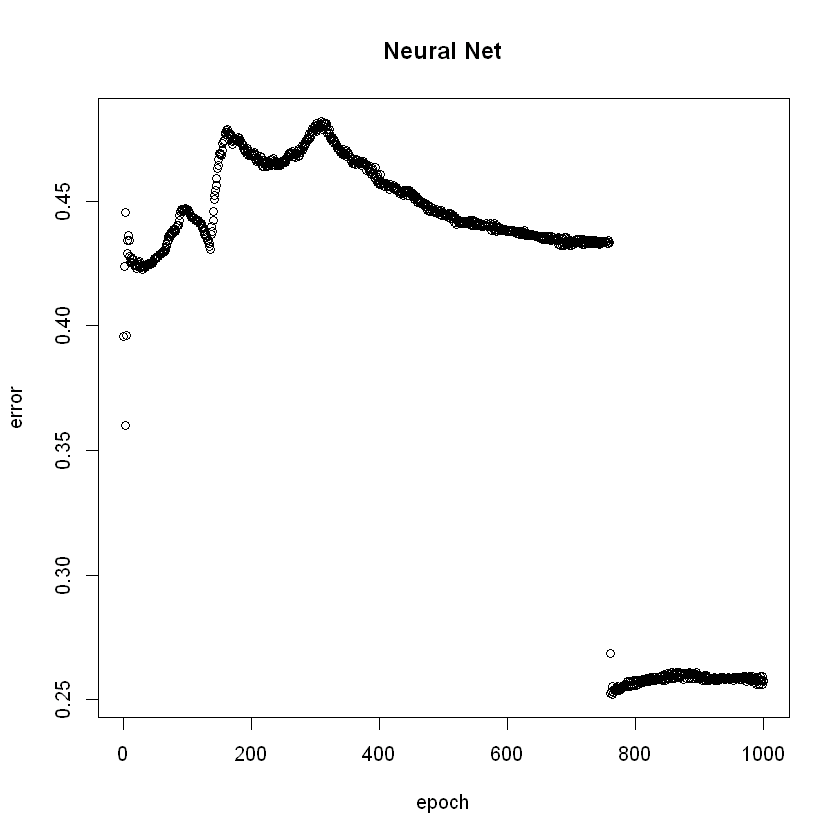

[1] "Completed :  88"


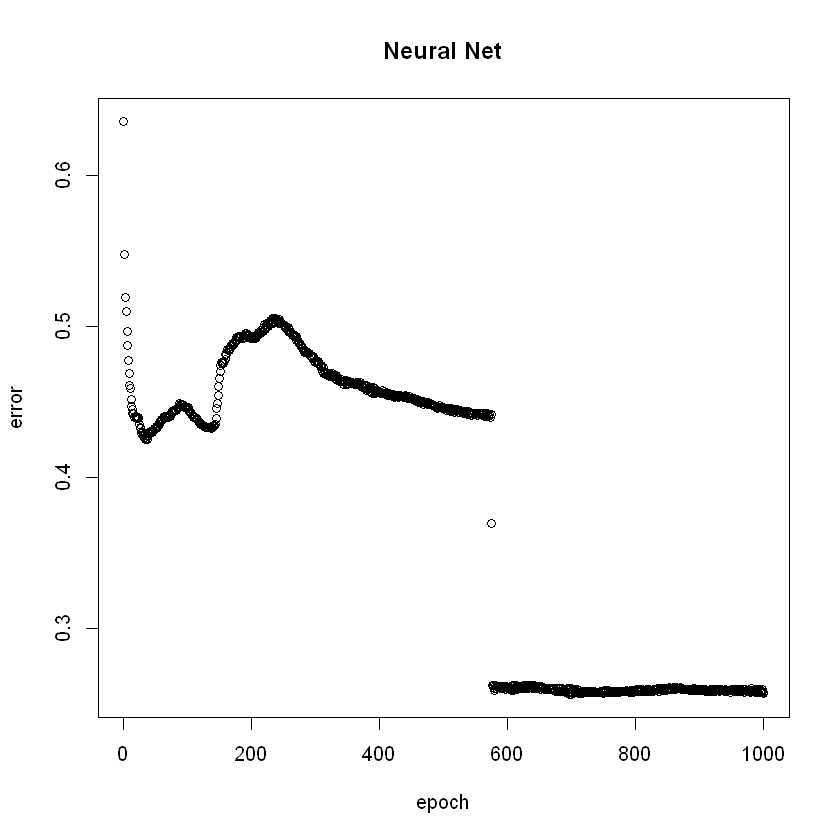

[1] "Completed :  90"


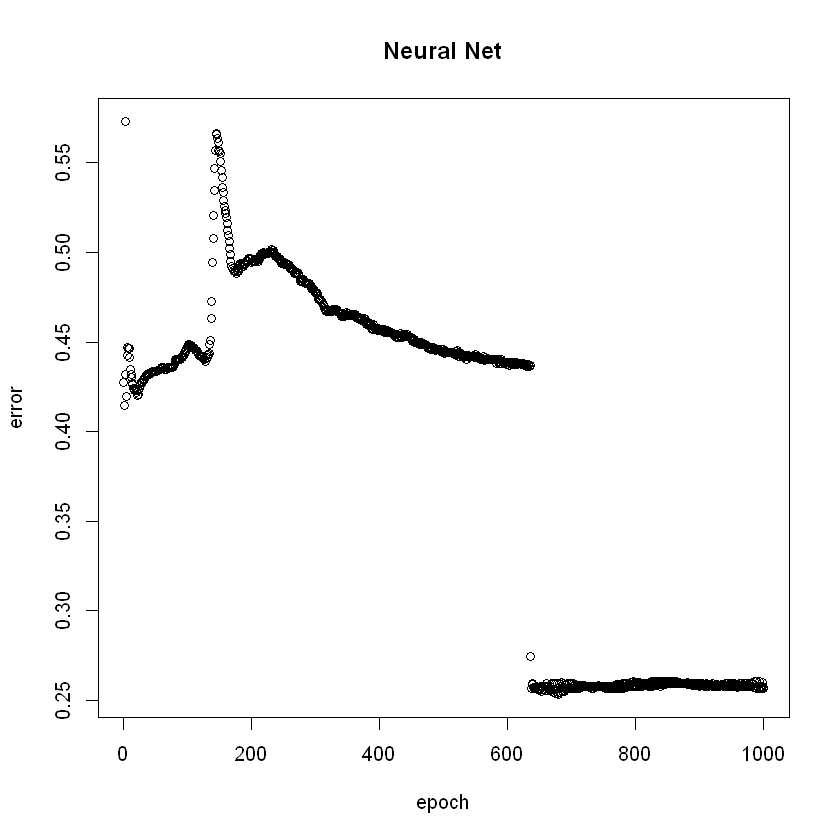

[1] "Completed :  92"


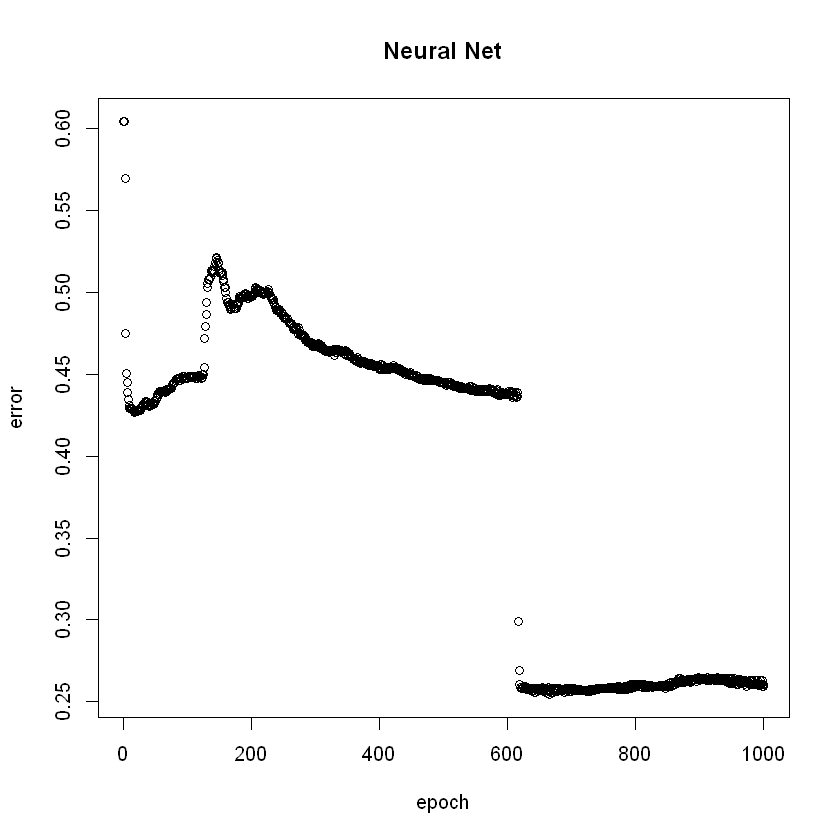

[1] "Completed :  94"


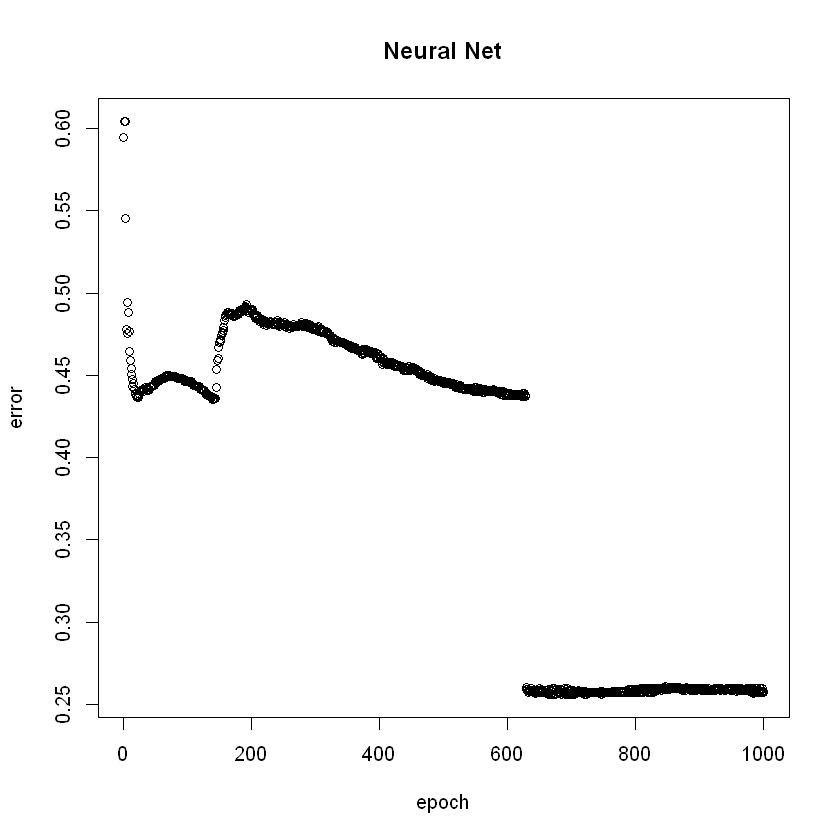

[1] "Completed :  96"


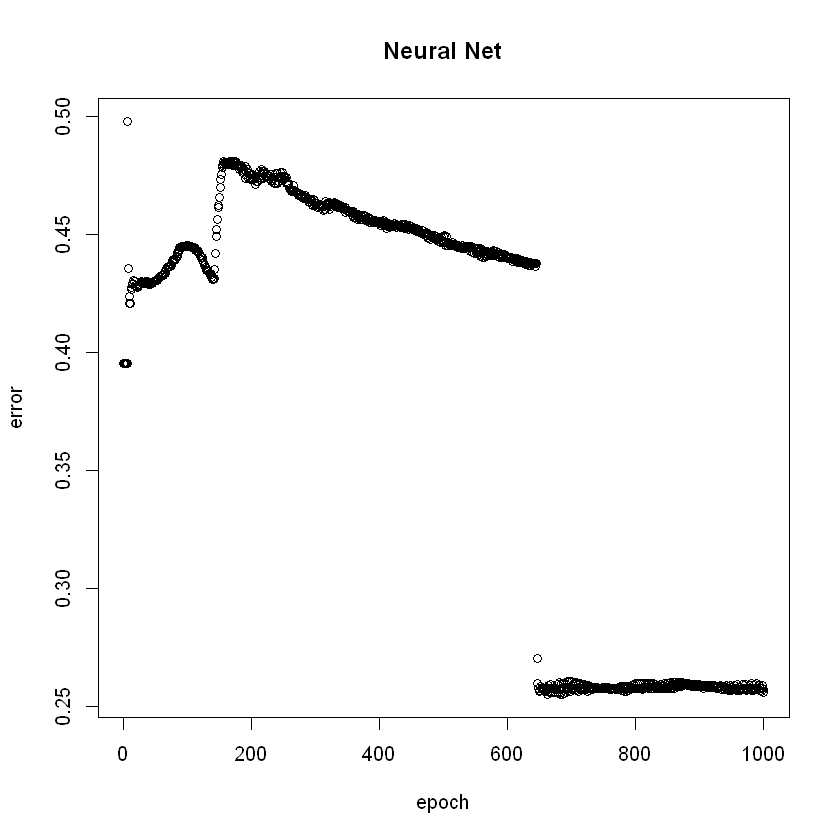

[1] "Completed :  98"


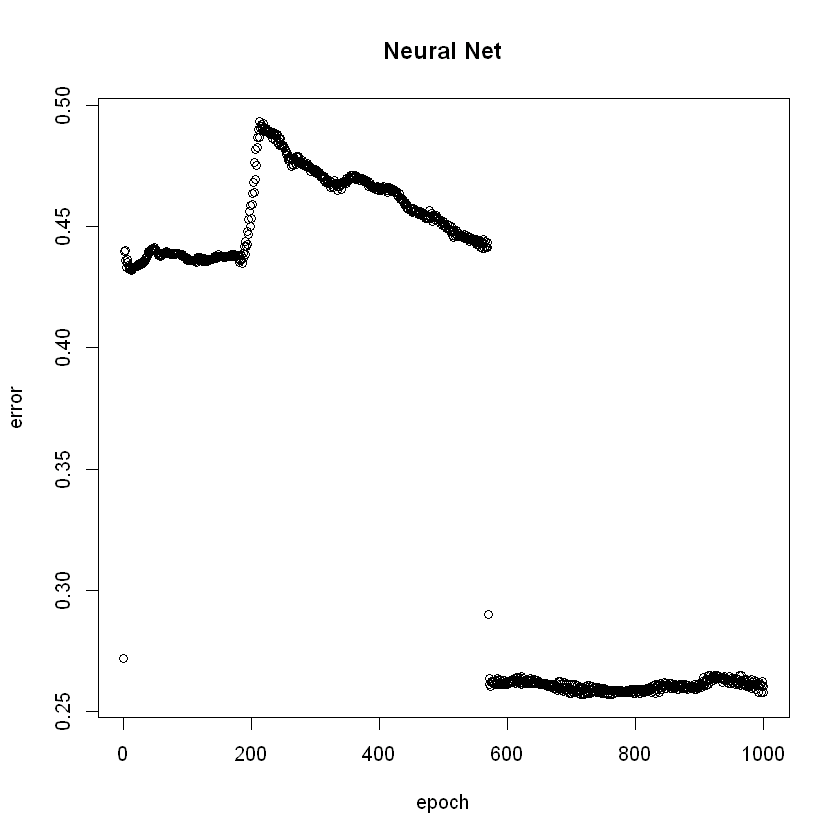

[1] "Completed :  100"


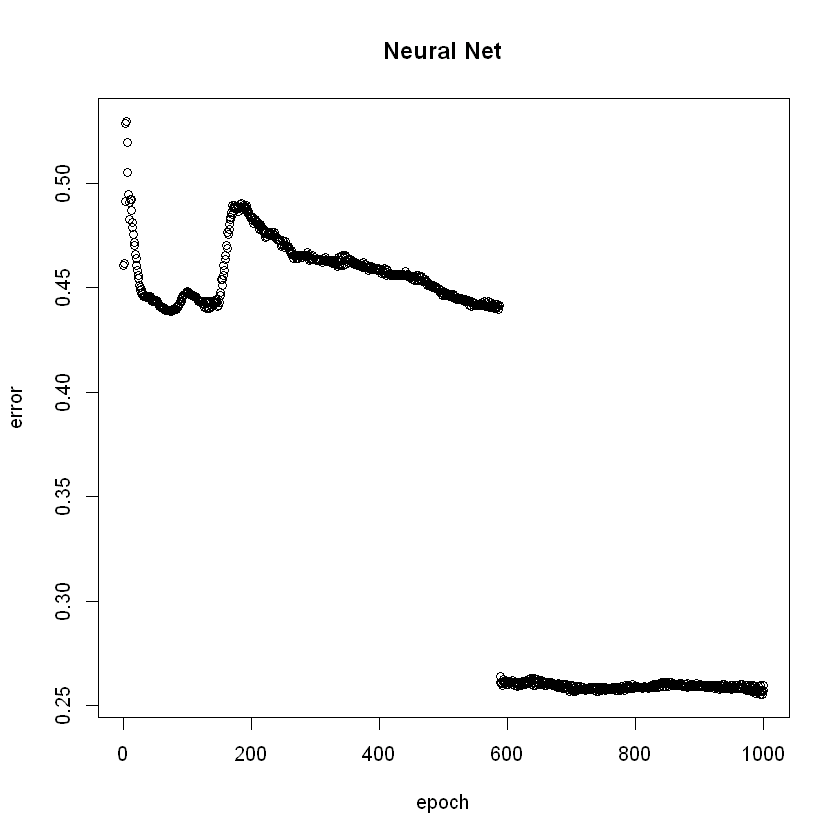

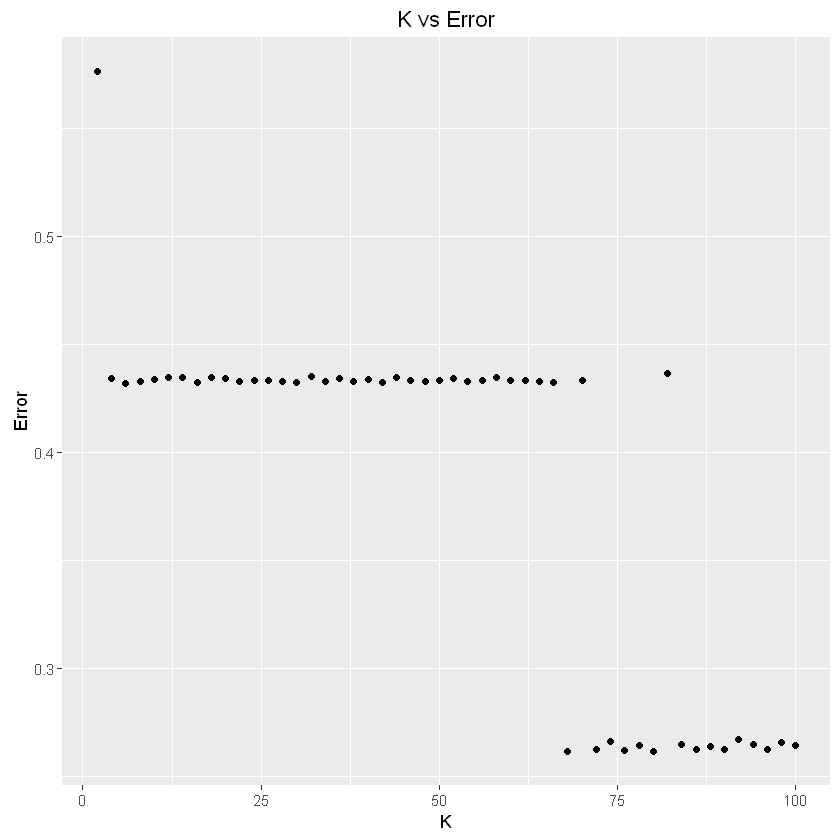

In [15]:
# transpose.
X1.t <- t(as.matrix(X1))
X2.t <- t(as.matrix(X2))

# container for storing errors whilst changing number of units in the hidden layer.
errTrace_ <- matrix(1, nrow = length(seq(2, 100, 2)), ncol = 2);

for (k in seq(2, 100, 2)) {
    list[W1, W2, b1, b2] <- nn.build(k, X1.t, T1, plotting = FALSE, epoch.max = 1000, eta = 0.1, lambda = 0.01)
    # predict labels using weights.
    pred_ <- nn.predict(X2.t, W1, W2, b1, b2);
    # record the number of hidden units in layer and error.
    

    print(paste("Completed : ", k));
    #? Evaluate the model (TO BE COMPLETE)
  
    #? Record the test errors for plotting purposes (TO BE COMPLETE)
    errTrace_[k / 2, 1] <- k # k
    errTrace_[k / 2, 2] <- error.rate(pred_, T2);

    # get best params 
    if (errTrace_[k/2,2] <= min(errTrace_[,2])) {
        best_ <- list(W1, W2, b1, b2,k);
    }
    

}

errTrace_ <- as.data.frame(errTrace_)
colnames(errTrace_) <- c("K","Error")

ggplot(data = errTrace_, aes(x = errTrace_$K, y = errTrace_$Error)) + geom_point() + ggtitle("K vs Error") + xlab("K") + ylab("Error")

In [16]:
# Get the best K
bestK_ <- errTrace_[errTrace_$Error == min(errTrace_$Error),]
print(bestK_);

    K  Error
34 68 0.2616
40 80 0.2616


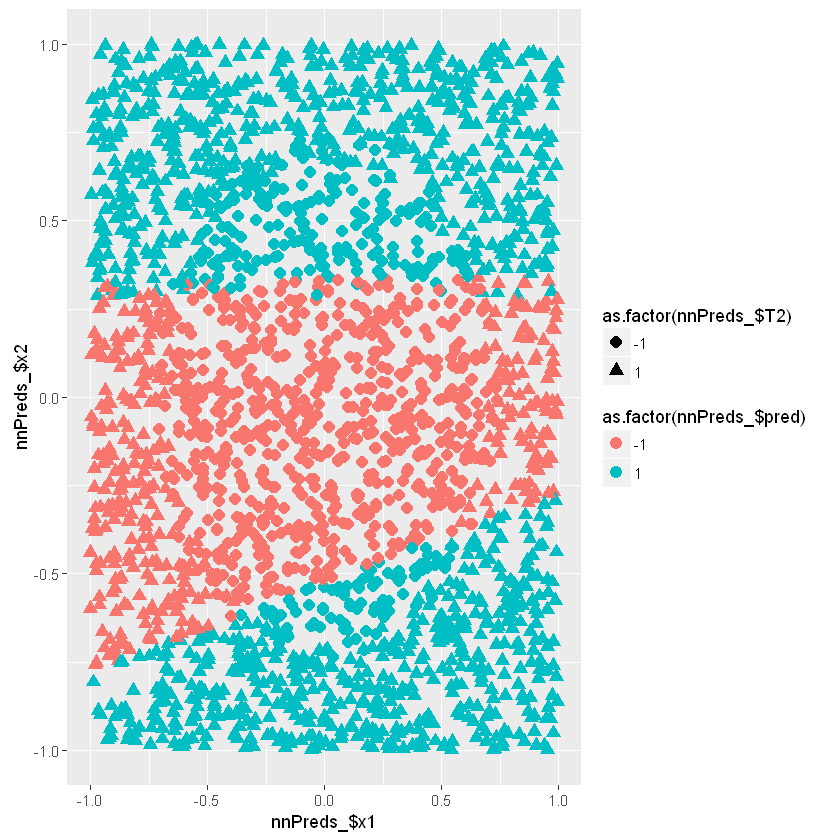

In [17]:
# Plot the predicted labels and actual labels.
# make predictions based on best params.
nnPreds_ <- nn.predict(X2.t,best_[[1]],best_[[2]],best_[[3]],best_[[4]])

# transpose
nnPreds_ <- t(nnPreds_)

#cbind x1,x2, labels
nnPreds_ <- cbind(X2, nnPreds_, T2)

#rename colnames
colnames(nnPreds_)[3] <- "pred"

# plot
ggplot(data = nnPreds_,aes(x=nnPreds_$x1,y=nnPreds_$x2)) + geom_point(aes(colour=as.factor(nnPreds_$pred),shape=as.factor(nnPreds_$T2)),size=3) + ggtitle("NN Prediction vs Actual") + xlab("X1") + ylab("X1")


### iv
In a table, report the error rates obtained by the perceptron and all variants of NN. Then bold the best model (with minimum error). Add this table to your report.

In [20]:
table_ <- rbind(cbind("perceptron", perceptronError_), as.matrix(errTrace_))
colnames(table_) <- c("K","Error")
table_

K,Error
perceptron,0.514
2,0.5768
4,0.4344
6,0.432
8,0.4332
10,0.434
12,0.4348
14,0.4348
16,0.4324
18,0.4348
